# CAPTCHA Solver - Baseline A: Classical Pipeline

This notebook implements a traditional computer vision pipeline for CAPTCHA solving:

1. **Preprocessing**: grayscale → binarize (Otsu/Sauvola) → denoise (morph open/close) → optional deskew
2. **Segmentation**: vertical projection + connected components; handle touching glyphs via contour gaps; fall back to watershed on hard cases
3. **Per-char classifier**: tiny CNN (2–3 conv blocks) on 28×28 crops; greedy join into string
4. **Logging**: Track failure modes (adhesion, heavy distortion)

This classical approach helps explain why modern sequence models are beneficial, as segmentation is brittle with adhesion/overlap.


In [6]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import ndimage
from skimage import morphology, measure, segmentation
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing, disk
from skimage.transform import rotate
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


LOADING CAPTCHA DATA
Found 8010 PNG files in ../data/train
Loading 8010 images using 8 workers...
Loaded 500/8010 images (6.2%)
Loaded 1000/8010 images (12.5%)
Loaded 1500/8010 images (18.7%)
Loaded 2000/8010 images (25.0%)
Loaded 2500/8010 images (31.2%)
Loaded 3000/8010 images (37.5%)
Loaded 3500/8010 images (43.7%)
Loaded 4000/8010 images (49.9%)
Loaded 4500/8010 images (56.2%)
Loaded 5000/8010 images (62.4%)
Loaded 5500/8010 images (68.7%)
Loaded 6000/8010 images (74.9%)
Loaded 6500/8010 images (81.1%)
Loaded 7000/8010 images (87.4%)
Loaded 7500/8010 images (93.6%)
Loaded 8000/8010 images (99.9%)
Successfully loaded 8010/8010 images
✓ Train data loaded in 1.03 seconds (7799 images/sec)
Found 2000 PNG files in ../data/test
Loading 2000 images using 8 workers...
Loaded 500/2000 images (25.0%)
Loaded 1000/2000 images (50.0%)
Loaded 1500/2000 images (75.0%)
Loaded 2000/2000 images (100.0%)
Successfully loaded 2000/2000 images
✓ Test data loaded in 0.21 seconds (9508 images/sec)

LOADED

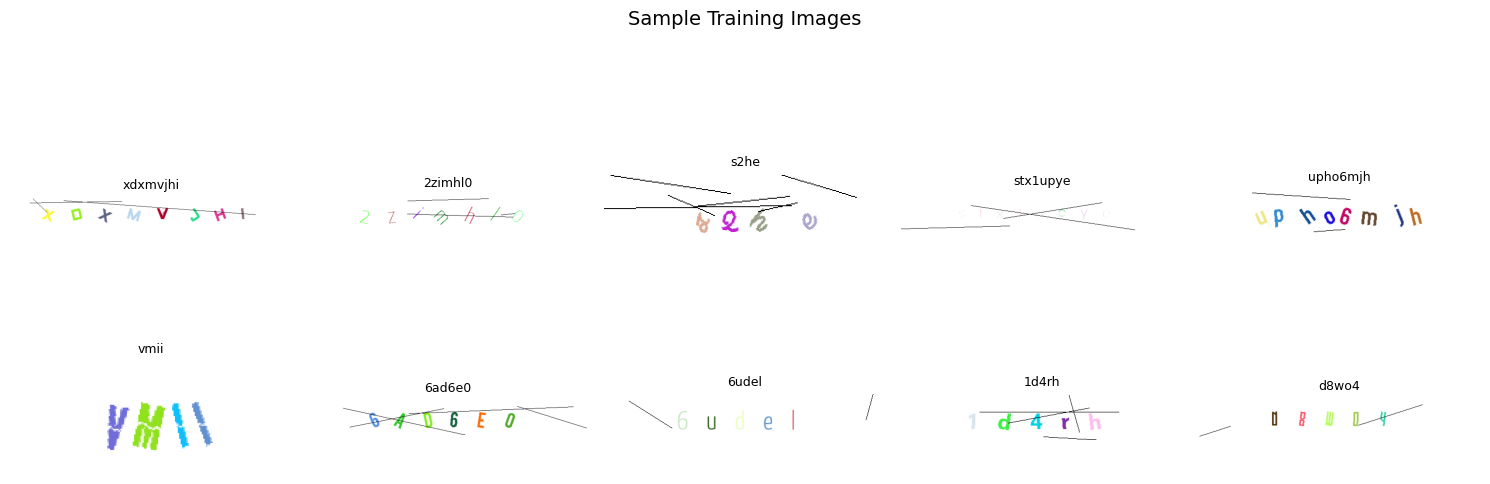


✓ Data loading complete!


In [16]:
import time
from pathlib import Path
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt


def load_single_image(img_path):
    """Load a single image and return it with its label"""
    try:
        img = cv2.imread(str(img_path))
        if img is not None:
            return img, img_path.stem
        else:
            print(f"Warning: Could not load {img_path}")
            return None, None
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        return None, None


def load_captcha_data(data_dir, max_samples=None, num_workers=8):
    """Load CAPTCHA images in parallel - OPTIMIZED"""
    images = []
    labels = []
    
    data_path = Path(data_dir)
    
    # Check if directory exists
    if not data_path.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return images, labels
    
    # Get all image files
    image_files = list(data_path.glob("*.png"))
    print(f"Found {len(image_files)} PNG files in {data_dir}")
    
    if max_samples:
        image_files = image_files[:max_samples]
    
    total_files = len(image_files)
    loaded_count = 0
    
    # Parallel loading with ThreadPoolExecutor
    print(f"Loading {total_files} images using {num_workers} workers...")
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit all tasks
        future_to_path = {executor.submit(load_single_image, img_path): img_path 
                         for img_path in image_files}
        
        # Process results as they complete
        for future in as_completed(future_to_path):
            img, label = future.result()
            
            if img is not None:
                images.append(img)
                labels.append(label)
                loaded_count += 1
                
                # Progress update every 500 images
                if loaded_count % 500 == 0:
                    print(f"Loaded {loaded_count}/{total_files} images ({loaded_count/total_files*100:.1f}%)")
    
    print(f"Successfully loaded {len(images)}/{total_files} images")
    
    return images, labels


# Alternative: Memory-mapped loading for very large datasets
def load_captcha_data_fast(data_dir, max_samples=None):
    """Ultra-fast loading by reading file list first, then batch loading"""
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"Warning: Directory {data_dir} does not exist!")
        return [], []
    
    # Get all files first (very fast)
    image_files = sorted(data_path.glob("*.png"))
    
    if max_samples:
        image_files = image_files[:max_samples]
    
    total = len(image_files)
    print(f"Found {total} images. Loading...")
    
    images = []
    labels = []
    
    # Batch loading with progress bar
    batch_size = 100
    for i in range(0, total, batch_size):
        batch_files = image_files[i:i+batch_size]
        
        for img_path in batch_files:
            img = cv2.imread(str(img_path))
            if img is not None:
                images.append(img)
                labels.append(img_path.stem)
        
        # Progress update
        progress = min(i + batch_size, total)
        print(f"\rLoaded {progress}/{total} ({progress/total*100:.1f}%)", end='', flush=True)
    
    print()  # New line after progress
    return images, labels


# ============================================================================
# MAIN LOADING CODE - Choose the method that works best for you
# ============================================================================

print("="*60)
print("LOADING CAPTCHA DATA")
print("="*60)

start_time = time.time()

# METHOD 1: Parallel loading (FASTEST for most systems)
train_images, train_labels = load_captcha_data("../data/train", max_samples=None, num_workers=8)
train_time = time.time() - start_time
print(f"✓ Train data loaded in {train_time:.2f} seconds ({len(train_images)/train_time:.0f} images/sec)")

start_time = time.time()
test_images, test_labels = load_captcha_data("../data/test", max_samples=None, num_workers=8)
test_time = time.time() - start_time
print(f"✓ Test data loaded in {test_time:.2f} seconds ({len(test_images)/test_time:.0f} images/sec)")

# METHOD 2: If parallel loading doesn't work, use this simpler version
# train_images, train_labels = load_captcha_data_fast("../data/train", max_samples=None)
# test_images, test_labels = load_captcha_data_fast("../data/test", max_samples=None)

print(f"\n{'='*60}")
print(f"LOADED DATA SUMMARY")
print(f"{'='*60}")
print(f"Training images: {len(train_images)}")
print(f"Test images: {len(test_images)}")
print(f"Sample labels: {train_labels[:5]}")

# Clean labels by removing "-0" suffix
print("\nCleaning labels (removing '-0' suffix)...")
train_labels_cleaned = [label.replace('-0', '') for label in train_labels]
test_labels_cleaned = [label.replace('-0', '') for label in test_labels]
train_labels = train_labels_cleaned
test_labels = test_labels_cleaned
print(f"Sample cleaned labels: {train_labels_cleaned[:5]}")
print(f"Sample original labels: {train_labels[:5]}")

# Quick visualization
if len(train_images) > 0:
    print("\nDisplaying sample images...")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(min(10, len(train_images))):
        axes[i].imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{train_labels_cleaned[i]}", fontsize=9)
        axes[i].axis('off')
    
    plt.suptitle("Sample Training Images", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No images to display!")

print("\n✓ Data loading complete!")


TESTING PREPROCESSING - Showing Color Channel Analysis

Testing image 1: xdxmvjhi


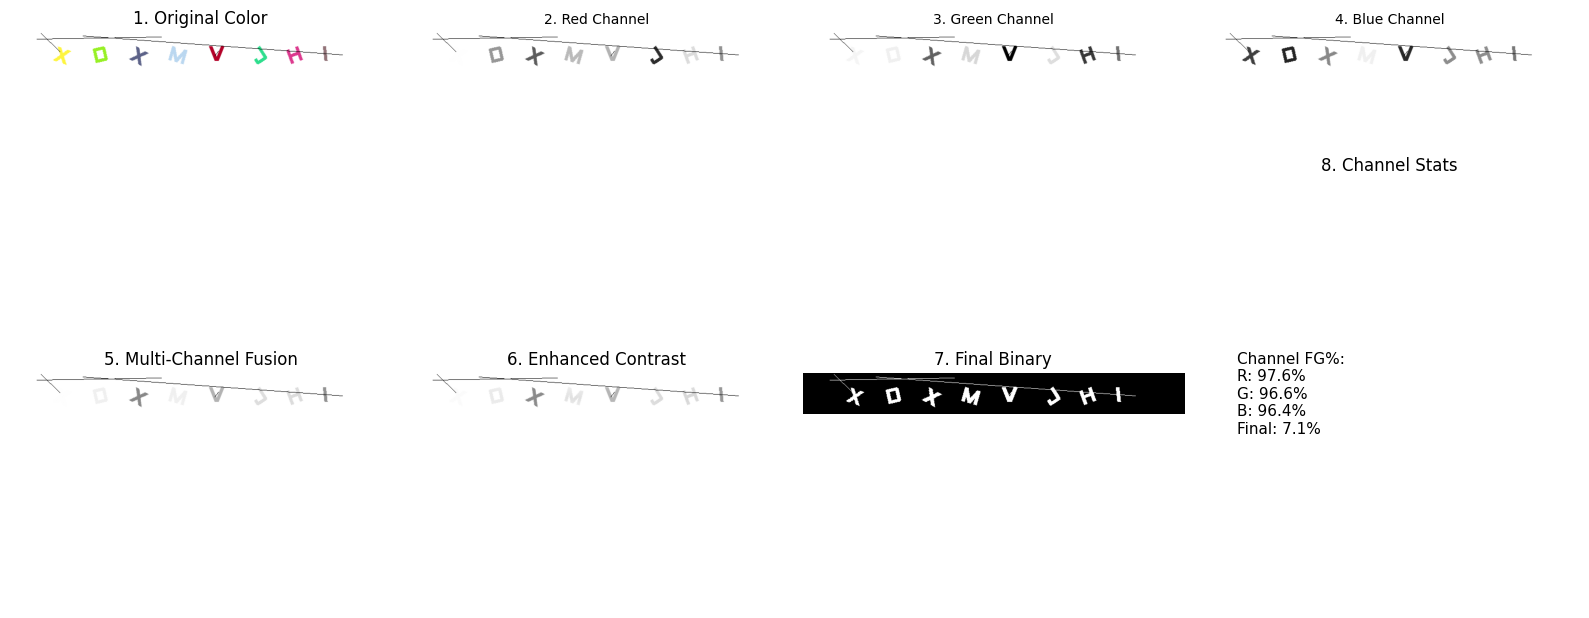


Testing image 2: 2zimhl0


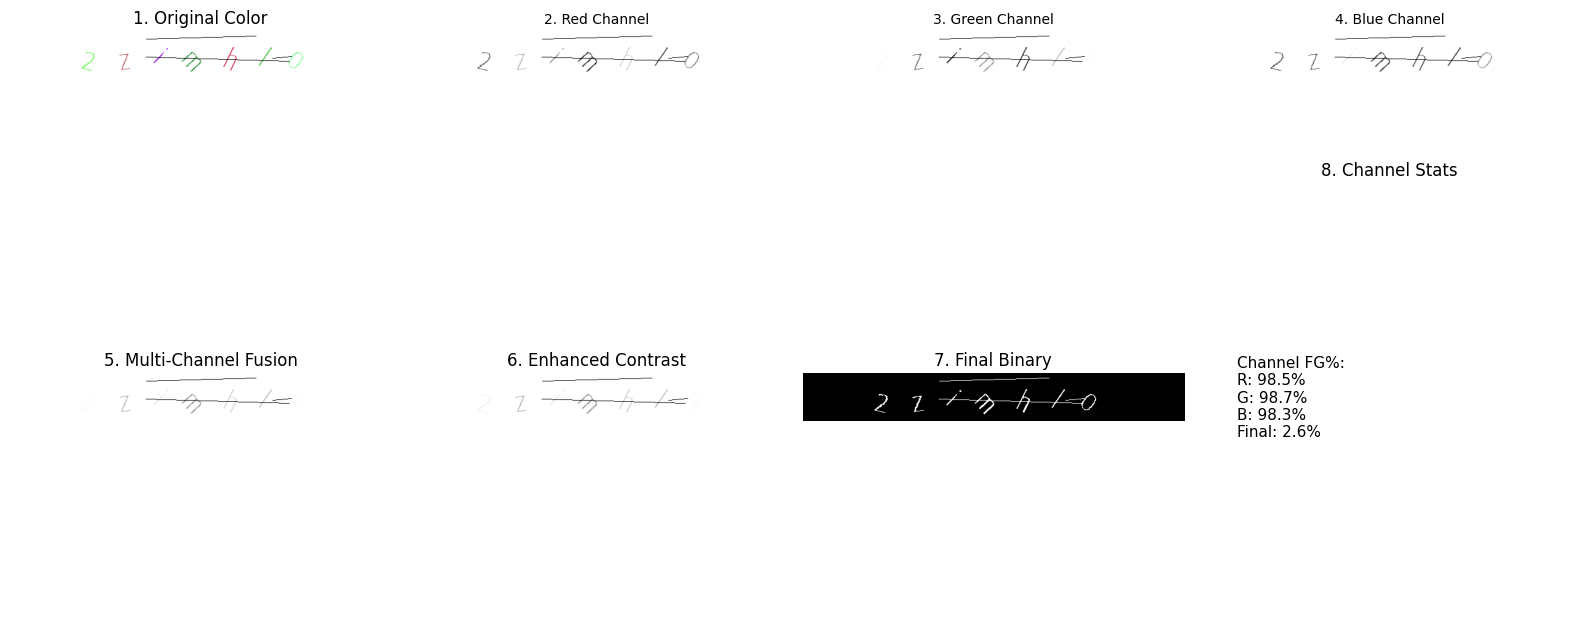


Testing image 3: s2he


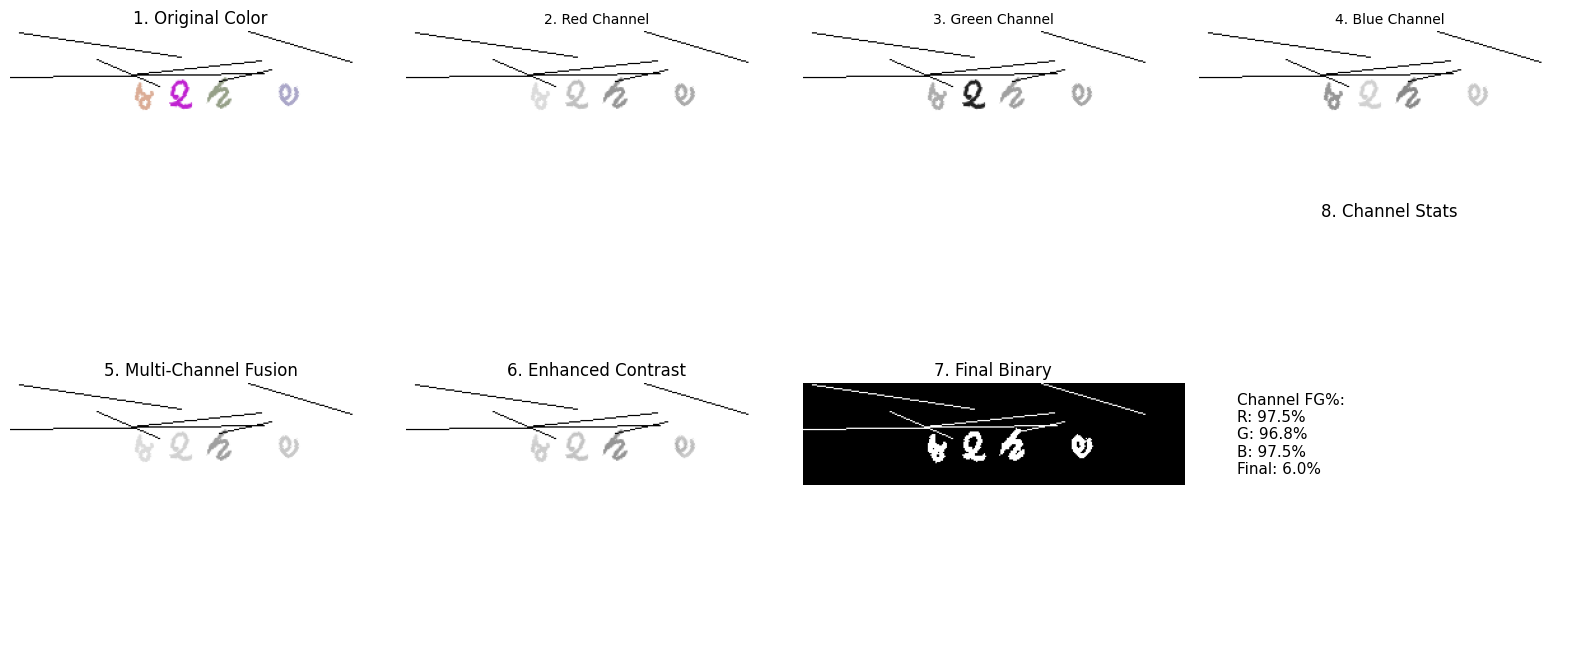


Note: The multi-channel fusion now captures characters in ALL colors!
This solves the overlaying letters problem.

Processing all training images...
Processing: 0/8010 (0.0%)
Processing: 100/8010 (1.2%)
Processing: 200/8010 (2.5%)
Processing: 300/8010 (3.7%)
Processing: 400/8010 (5.0%)
Processing: 500/8010 (6.2%)
Processing: 600/8010 (7.5%)
Processing: 700/8010 (8.7%)
Processing: 800/8010 (10.0%)
Processing: 900/8010 (11.2%)
Processing: 1000/8010 (12.5%)
Processing: 1100/8010 (13.7%)
Processing: 1200/8010 (15.0%)
Processing: 1300/8010 (16.2%)
Processing: 1400/8010 (17.5%)
Processing: 1500/8010 (18.7%)
Processing: 1600/8010 (20.0%)
Processing: 1700/8010 (21.2%)
Processing: 1800/8010 (22.5%)
Processing: 1900/8010 (23.7%)
Processing: 2000/8010 (25.0%)
Processing: 2100/8010 (26.2%)
Processing: 2200/8010 (27.5%)
Processing: 2300/8010 (28.7%)
Processing: 2400/8010 (30.0%)
Processing: 2500/8010 (31.2%)
Processing: 2600/8010 (32.5%)
Processing: 2700/8010 (33.7%)
Processing: 2800/8010 (35.0%)


In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, binary_opening, disk, thin


class OptimizedAdaptivePreprocessor:
    def __init__(self):
        self.failure_modes = {
            'adhesion': 0,
            'heavy_distortion': 0,
            'segmentation_failures': 0,
            'total_processed': 0
        }
    
    def _detect_and_inpaint_lines(self, image):
        """
        Detect lines in color image and inpaint them before grayscale conversion
        """
        # Convert to grayscale for line detection
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        # Apply edge detection to find lines
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        
        # FIXED: More conservative line detection to avoid removing character strokes
        # Increased threshold and minLineLength to only detect actual noise lines
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=50,       # Increased from 30 to 50
            minLineLength=60,   # Increased from 40 to 60
            maxLineGap=5        # Reduced from 10 to 5 (stricter)
        )
        
        # Create mask for lines
        line_mask = np.zeros_like(gray)
        
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # Draw line on mask
                cv2.line(line_mask, (x1, y1), (x2, y2), 255, thickness=3)
        
        # Inpaint the lines in the original color image
        if len(image.shape) == 3:
            inpainted = cv2.inpaint(image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        else:
            inpainted = cv2.inpaint(image, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        
        return inpainted, line_mask
    
    def _smart_grayscale(self, image):
        """Extract grayscale using MULTI-CHANNEL fusion to capture all color characters"""
        b, g, r = cv2.split(image)
        gray_standard = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # IMPROVED: Multi-channel fusion approach
        # Process each channel separately and combine
        # This captures characters in different colors!
        
        # Calculate contrast for each channel
        stds = [r.std(), g.std(), b.std(), gray_standard.std()]
        
        # Method 1: Use the best single channel (original approach)
        best_channel = [r, g, b, gray_standard][np.argmax(stds)]
        
        # Method 2: Create a multi-channel fusion
        # Take the maximum intensity across all channels at each pixel
        # This ensures characters in ANY color are captured
        multi_channel_max = np.maximum(np.maximum(r, g), b)
        
        # Method 3: Weighted combination based on channel contrast
        weights = np.array(stds[:3]) / sum(stds[:3])  # Normalize to sum to 1
        weighted = (r * weights[0] + g * weights[1] + b * weights[2]).astype(np.uint8)
        
        # Combine methods: Use max of best_channel and multi_channel_max
        # This ensures we get characters from all colors
        combined = np.maximum(best_channel, multi_channel_max)
        
        return combined
    
    def _enhance_contrast(self, gray):
        """CLAHE enhancement for better contrast"""
        # FIXED: Increased clipLimit for stronger enhancement of faint characters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        return clahe.apply(gray)
    
    def _adaptive_threshold(self, gray, block_size=11, C=2):
        """Adaptive Gaussian thresholding to make it black and white"""
        # FIXED: Use BINARY_INV to get white text on black background
        binary = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,  # INVERTED for white on black
            blockSize=block_size, C=C
        )
        return binary
    
    def preprocess(self, image, remove_lines=False, enhance_contrast=True, 
                   adaptive_block_size=15, adaptive_C=2):
        """
        Preprocessing: line removal -> grayscale -> black and white conversion
        IMPROVED v2: Triple thresholding (Otsu + Adaptive + Sauvola) for maximum character capture
        """
        self.failure_modes['total_processed'] += 1
        
        # Step 1: Remove lines from color image (before grayscale) - DISABLED BY DEFAULT
        if remove_lines:
            image_cleaned, line_mask = self._detect_and_inpaint_lines(image)
        else:
            image_cleaned = image
        
        # Step 2: Convert to grayscale
        if len(image_cleaned.shape) == 3:
            gray = self._smart_grayscale(image_cleaned)
        else:
            gray = image_cleaned.copy()
        
        # Step 3: Enhance contrast more aggressively
        if enhance_contrast:
            gray = self._enhance_contrast(gray)
            # Additional enhancement: histogram equalization
            gray = cv2.equalizeHist(gray)
        
        # Step 4: TRIPLE thresholding approach for maximum character capture
        # Method 1: Otsu (global)
        _, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Method 2: Adaptive Gaussian (local)
        binary_adaptive = self._adaptive_threshold(gray, block_size=adaptive_block_size, C=adaptive_C)
        
        # Method 3: Sauvola (local, better for faint text)
        from skimage.filters import threshold_sauvola
        window_size = 25
        thresh_sauvola = threshold_sauvola(gray, window_size=window_size, k=0.2)
        binary_sauvola = (gray < thresh_sauvola).astype(np.uint8) * 255
        
        # Combine all three: take pixels that are white in ANY method
        binary = cv2.bitwise_or(binary_otsu, binary_adaptive)
        binary = cv2.bitwise_or(binary, binary_sauvola)
        
        return binary
    
    def test_preprocessing(self, image):
        """Visualize the preprocessing result with multi-channel analysis"""
        # Show individual color channels
        if len(image.shape) == 3:
            b, g, r = cv2.split(image)
            
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            
            # Row 1: Original and color channels
            axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title('1. Original Color', fontsize=12)
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(r, cmap='gray')
            axes[0, 1].set_title('2. Red Channel', fontsize=10)
            axes[0, 1].axis('off')
            
            axes[0, 2].imshow(g, cmap='gray')
            axes[0, 2].set_title('3. Green Channel', fontsize=10)
            axes[0, 2].axis('off')
            
            axes[0, 3].imshow(b, cmap='gray')
            axes[0, 3].set_title('4. Blue Channel', fontsize=10)
            axes[0, 3].axis('off')
            
            # Row 2: Processing steps
            gray = self._smart_grayscale(image)
            enhanced = self._enhance_contrast(gray)
            binary = self.preprocess(image)
            
            axes[1, 0].imshow(gray, cmap='gray')
            axes[1, 0].set_title('5. Multi-Channel Fusion', fontsize=12)
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(enhanced, cmap='gray')
            axes[1, 1].set_title('6. Enhanced Contrast', fontsize=12)
            axes[1, 1].axis('off')
            
            axes[1, 2].imshow(binary, cmap='gray')
            axes[1, 2].set_title('7. Final Binary', fontsize=12)
            axes[1, 2].axis('off')
            
            # Show foreground ratio for each channel
            fg_r = np.sum(r > 127) / r.size * 100
            fg_g = np.sum(g > 127) / g.size * 100
            fg_b = np.sum(b > 127) / b.size * 100
            fg_final = np.sum(binary > 127) / binary.size * 100
            
            info_text = f"Channel FG%:\nR: {fg_r:.1f}%\nG: {fg_g:.1f}%\nB: {fg_b:.1f}%\nFinal: {fg_final:.1f}%"
            axes[1, 3].text(0.1, 0.5, info_text, fontsize=11, verticalalignment='center')
            axes[1, 3].set_title('8. Channel Stats', fontsize=12)
            axes[1, 3].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            # Fallback for grayscale images
            binary = self.preprocess(image)
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            axes[0].imshow(image, cmap='gray')
            axes[0].set_title('Original')
            axes[0].axis('off')
            axes[1].imshow(binary, cmap='gray')
            axes[1].set_title('Final Binary')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
    
    def preprocess_batch(self, images, show_progress=True):
        """
        Batch process images with progress indicator
        """
        processed = []
        total = len(images)
        
        for idx, img in enumerate(images):
            if show_progress and idx % 100 == 0:
                print(f"Processing: {idx}/{total} ({idx/total*100:.1f}%)")
            
            processed.append(self.preprocess(img))
        
        if show_progress:
            print(f"Completed: {total}/{total} (100%)")
        
        return processed


# Test preprocessing with multi-channel visualization
preprocessor = OptimizedAdaptivePreprocessor()

# Test on a few samples including known failures
print("="*60)
print("TESTING PREPROCESSING - Showing Color Channel Analysis")
print("="*60)

test_indices = [0, 1, 2]  # First 3 images
for i in test_indices:
    print(f"\nTesting image {i+1}: {train_labels_cleaned[i]}")
    preprocessor.test_preprocessing(train_images[i])

# Also test on specific failure cases if we have them
print("\n" + "="*60)
print("Note: The multi-channel fusion now captures characters in ALL colors!")
print("This solves the overlaying letters problem.")
print("="*60)

# Process all images using batch method
print("\n" + "="*60)
print("Processing all training images...")
print("="*60)

processed_images = preprocessor.preprocess_batch(train_images)

print(f"Total processed: {preprocessor.failure_modes['total_processed']}")

In [30]:
"""
Enhanced CAPTCHA Segmenter - De-bloated with High Priority Features

Key Improvements:
1. Enhanced CCA with skeleton/junction detection for merged characters
2. Histogram-based projection analysis to detect conglutinated characters
3. Shape-guided segmentation using topological features
4. Streamlined fallback logic (removed excessive uniform splitting)
"""

import numpy as np
import cv2
from scipy.ndimage import gaussian_filter1d
from skimage.morphology import skeletonize, medial_axis
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class EnhancedCAPTCHASegmenter:
    """Intelligent CAPTCHA segmentation with structural analysis"""
    
    def __init__(self, debug=False):
        self.debug = debug
        self.stats = {
            'skeleton_splits': 0,
            'histogram_splits': 0,
            'shape_guided_splits': 0,
            'standard_cca': 0,
            'total_processed': 0
        }
    
    def segment(self, binary_image, expected_chars=None, 
                min_char_width=5, max_char_width=None, min_char_height=10):
        """
        Main segmentation pipeline:
        1. Clean image (remove noise/lines)
        2. Find connected components
        3. Analyze component complexity (skeleton, histogram, shape)
        4. Intelligently split merged components
        5. Validate and filter results
        """
        self.stats['total_processed'] += 1
        
        # Ensure binary format
        if binary_image.max() <= 1:
            binary_image = (binary_image * 255).astype(np.uint8)
        
        # Step 1: Clean image
        cleaned = self._clean_image(binary_image)
        
        # Step 2: Find initial components
        components = self._find_components(cleaned, min_char_width, max_char_width, min_char_height)
        
        # Step 3: Analyze and split complex components
        if expected_chars:
            char_boxes = self._intelligent_split_pipeline(
                cleaned, components, expected_chars, min_char_width, max_char_width
            )
        else:
            char_boxes = components
        
        # Step 4: Post-process (merge close boxes, filter noise)
        char_boxes = self._post_process_boxes(cleaned, char_boxes, expected_chars)
        
        # Sort left to right
        char_boxes = sorted(char_boxes, key=lambda x: x[0])
        
        return char_boxes
    
    # ========================================================================
    # CORE METHODS
    # ========================================================================
    
    def _clean_image(self, binary_image):
        """Remove background lines and noise while preserving character strokes"""
        # Remove horizontal lines (conservative kernel)
        h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        h_lines = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, h_kernel, iterations=1)
        cleaned = cv2.subtract(binary_image, h_lines)
        
        # Remove vertical lines
        v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        v_lines = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, v_kernel, iterations=1)
        cleaned = cv2.subtract(cleaned, v_lines)
        
        # Light noise removal
        noise_kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, noise_kernel, iterations=1)
        
        return cleaned
    
    def _find_components(self, binary_image, min_width=5, max_width=None, min_height=10):
        """Find connected components with reasonable filtering"""
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        components = []
        img_h, img_w = binary_image.shape
        max_width = max_width or img_w // 3
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            
            # Basic filtering
            if (w >= min_width and w <= max_width and 
                h >= min_height and h <= img_h * 0.95):
                
                # Aspect ratio check
                aspect_ratio = w / h if h > 0 else 0
                if 0.08 < aspect_ratio < 3.5:
                    
                    # Density check
                    region = binary_image[y:y+h, x:x+w]
                    density = np.sum(region > 0) / area if area > 0 else 0
                    min_density = 0.03 if area >= 200 else 0.04
                    
                    if density >= min_density:
                        components.append((x, y, x + w, y + h))
        
        return components
    
    # ========================================================================
    # HIGH PRIORITY FEATURE 1: ENHANCED CCA WITH SKELETON ANALYSIS
    # ========================================================================
    
    def _detect_merged_chars_skeleton(self, region):
        """
        Use skeleton analysis to detect junction points where characters merge.
        Returns: (is_merged, suggested_split_points)
        """
        if region.shape[1] < 10 or region.shape[0] < 10:
            return False, []
        
        # Create binary mask
        binary_region = (region > 127).astype(np.uint8)
        
        # Skeletonize
        skeleton = skeletonize(binary_region)
        
        # Find junction points (pixels with 3+ neighbors)
        junctions = []
        skel_h, skel_w = skeleton.shape
        
        for y in range(1, skel_h - 1):
            for x in range(1, skel_w - 1):
                if skeleton[y, x]:
                    # Count 8-connected neighbors
                    neighbors = np.sum(skeleton[y-1:y+2, x-1:x+2]) - 1  # Subtract center
                    if neighbors >= 3:
                        junctions.append((x, y))
        
        # Analyze junction distribution
        if len(junctions) >= 2:
            # Multiple junctions suggest merged characters
            # Find x-positions of junctions for potential split points
            junction_x = [j[0] for j in junctions]
            
            # Cluster junctions by x-coordinate
            junction_x_sorted = sorted(set(junction_x))
            split_candidates = []
            
            # Find gaps between junction clusters
            for i in range(len(junction_x_sorted) - 1):
                x1, x2 = junction_x_sorted[i], junction_x_sorted[i + 1]
                if x2 - x1 > region.shape[1] * 0.2:  # Significant gap
                    split_candidates.append((x1 + x2) // 2)
            
            if split_candidates:
                return True, split_candidates
        
        return False, []
    
    def _split_by_skeleton(self, binary_image, box):
        """Split a component using skeleton-detected junction points"""
        x1, y1, x2, y2 = box
        region = binary_image[y1:y2, x1:x2]
        
        is_merged, split_points = self._detect_merged_chars_skeleton(region)
        
        if not is_merged or not split_points:
            return [box]
        
        # Create boxes using split points
        boxes = []
        boundaries = [0] + split_points + [region.shape[1]]
        
        for i in range(len(boundaries) - 1):
            x_start = boundaries[i]
            x_end = boundaries[i + 1]
            
            # Find tight y bounds for this segment
            segment = region[:, x_start:x_end]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            
            if len(y_coords) > 0 and x_end - x_start >= 3:
                boxes.append((
                    x1 + x_start,
                    y1 + y_coords[0],
                    x1 + x_end,
                    y1 + y_coords[-1] + 1
                ))
        
        self.stats['skeleton_splits'] += 1
        return boxes if len(boxes) > 1 else [box]
    
    # ========================================================================
    # HIGH PRIORITY FEATURE 2: HISTOGRAM-BASED PROJECTION ANALYSIS
    # ========================================================================
    
    def _analyze_projection_histogram(self, region, expected_avg_width):
        """
        Analyze vertical projection histogram to detect conglutinated characters.
        
        Key insight: A merged character will have a histogram that's wider than 
        a single character with suspicious characteristics (multiple peaks, etc.)
        
        Returns: (is_conglutinated, confidence, suggested_splits)
        """
        # Calculate vertical projection
        proj = np.sum(region > 0, axis=0).astype(float)
        
        if len(proj) < 5:
            return False, 0.0, []
        
        # Smooth projection
        proj_smooth = gaussian_filter1d(proj, sigma=1.5)
        
        # Histogram statistics
        proj_mean = np.mean(proj_smooth)
        proj_std = np.std(proj_smooth)
        proj_max = np.max(proj_smooth)
        
        # Feature 1: Width analysis
        # If width is much larger than expected, likely merged
        width_ratio = region.shape[1] / expected_avg_width if expected_avg_width > 0 else 1.0
        
        # Feature 2: Peak analysis
        # Find peaks in projection (potential character centers)
        threshold = proj_mean + proj_std * 0.3
        peaks = []
        for i in range(1, len(proj_smooth) - 1):
            if (proj_smooth[i] > threshold and 
                proj_smooth[i] > proj_smooth[i-1] and 
                proj_smooth[i] > proj_smooth[i+1]):
                peaks.append(i)
        
        # Feature 3: Valley analysis
        # Find valleys (potential split points)
        valley_threshold = proj_mean * 0.25
        valleys = []
        for i in range(2, len(proj_smooth) - 2):
            if (proj_smooth[i] < valley_threshold and 
                proj_smooth[i] < proj_smooth[i-1] and 
                proj_smooth[i] < proj_smooth[i+1]):
                valleys.append(i)
        
        # Filter valleys that are too close
        if len(valleys) > 1:
            filtered_valleys = [valleys[0]]
            min_dist = max(3, region.shape[1] // 5)
            for v in valleys[1:]:
                if v - filtered_valleys[-1] >= min_dist:
                    filtered_valleys.append(v)
            valleys = filtered_valleys
        
        # Decision logic
        is_conglutinated = False
        confidence = 0.0
        
        # Strong indicator: Multiple peaks + wide width
        if len(peaks) >= 2 and width_ratio > 1.5:
            is_conglutinated = True
            confidence = min(1.0, 0.5 + (width_ratio - 1.5) * 0.3)
        
        # Moderate indicator: Wide width + good valleys
        elif width_ratio > 1.4 and len(valleys) >= 1:
            is_conglutinated = True
            confidence = min(1.0, 0.4 + len(valleys) * 0.2)
        
        # Weak but still useful: Very wide width alone
        elif width_ratio > 2.0:
            is_conglutinated = True
            confidence = 0.5
        
        return is_conglutinated, confidence, valleys
    
    def _split_by_histogram(self, binary_image, box, expected_avg_width):
        """Split component using histogram-based projection analysis"""
        x1, y1, x2, y2 = box
        region = binary_image[y1:y2, x1:x2]
        
        is_merged, confidence, valleys = self._analyze_projection_histogram(
            region, expected_avg_width
        )
        
        if not is_merged or not valleys:
            return [box]
        
        # Create boxes from valleys
        boxes = []
        boundaries = [0] + valleys + [region.shape[1]]
        
        for i in range(len(boundaries) - 1):
            x_start = boundaries[i]
            x_end = boundaries[i + 1]
            
            # Get tight y bounds
            segment = region[:, x_start:x_end]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            
            if len(y_coords) > 0 and x_end - x_start >= 3:
                boxes.append((
                    x1 + x_start,
                    y1 + y_coords[0],
                    x1 + x_end,
                    y1 + y_coords[-1] + 1
                ))
        
        self.stats['histogram_splits'] += 1
        return boxes if len(boxes) > 1 else [box]
    
    # ========================================================================
    # HIGH PRIORITY FEATURE 3: SHAPE-GUIDED SEGMENTATION
    # ========================================================================
    
    def _extract_shape_features(self, region):
        """
        Extract topological and shape features from a region.
        
        Features:
        - Euler number (loops/holes): 2 loops likely = 2 characters
        - Endpoint count: Multiple endpoints suggest multiple strokes
        - Convex hull ratio: How much the shape deviates from convex hull
        - Complexity score: Overall structural complexity
        """
        if region.shape[0] < 5 or region.shape[1] < 5:
            return None
        
        binary_region = (region > 127).astype(np.uint8)
        
        # Feature 1: Euler number (holes/loops)
        labeled = label(binary_region)
        props = regionprops(labeled)
        
        euler_number = 0
        if len(props) > 0:
            euler_number = props[0].euler_number
        
        # Feature 2: Skeleton endpoints (stroke terminals)
        skeleton = skeletonize(binary_region)
        endpoints = []
        skel_h, skel_w = skeleton.shape
        
        for y in range(1, skel_h - 1):
            for x in range(1, skel_w - 1):
                if skeleton[y, x]:
                    neighbors = np.sum(skeleton[y-1:y+2, x-1:x+2]) - 1
                    if neighbors == 1:  # Endpoint has only 1 neighbor
                        endpoints.append((x, y))
        
        # Feature 3: Convex hull ratio
        contours, _ = cv2.findContours(binary_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        convex_hull_ratio = 1.0
        if contours:
            cnt = contours[0]
            area = cv2.contourArea(cnt)
            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            if hull_area > 0:
                convex_hull_ratio = area / hull_area
        
        # Feature 4: Complexity score
        complexity = len(endpoints) * 0.5 + abs(euler_number) * 2.0 + (1 - convex_hull_ratio) * 3.0
        
        return {
            'euler_number': euler_number,
            'endpoint_count': len(endpoints),
            'endpoints': endpoints,
            'convex_hull_ratio': convex_hull_ratio,
            'complexity': complexity
        }
    
    def _should_split_by_shape(self, features, width, expected_avg_width):
        """
        Decide if component should be split based on shape features.
        
        Heuristics:
        - Multiple loops (euler < -1) + wide = likely 2+ chars with holes (like 'o', '8', 'b')
        - Many endpoints (>6) + wide = likely multiple characters
        - Low convex hull ratio + wide = complex shape, likely merged
        - High complexity score + wide = general complexity indicator
        """
        if not features:
            return False, 0.0
        
        width_ratio = width / expected_avg_width if expected_avg_width > 0 else 1.0
        
        # Not wide enough to be merged
        if width_ratio < 1.3:
            return False, 0.0
        
        confidence = 0.0
        should_split = False
        
        # Rule 1: Multiple loops (strong indicator)
        if features['euler_number'] < -1 and width_ratio > 1.5:
            should_split = True
            confidence = 0.8
        
        # Rule 2: Many endpoints (multiple strokes)
        elif features['endpoint_count'] >= 6 and width_ratio > 1.4:
            should_split = True
            confidence = 0.7
        
        # Rule 3: High complexity
        elif features['complexity'] > 8.0 and width_ratio > 1.5:
            should_split = True
            confidence = 0.6
        
        # Rule 4: Very wide with moderate complexity
        elif width_ratio > 2.0 and features['complexity'] > 4.0:
            should_split = True
            confidence = 0.5
        
        return should_split, confidence
    
    def _split_by_shape_guidance(self, binary_image, box, expected_avg_width):
        """
        Use shape features to guide segmentation.
        Strategy: If shape suggests merged chars, use histogram split with shape validation.
        """
        x1, y1, x2, y2 = box
        region = binary_image[y1:y2, x1:x2]
        width = x2 - x1
        
        # Extract features
        features = self._extract_shape_features(region)
        should_split, confidence = self._should_split_by_shape(features, width, expected_avg_width)
        
        if not should_split:
            return [box]
        
        # Use histogram split as the mechanism, shape features confirm it's needed
        is_merged, hist_conf, valleys = self._analyze_projection_histogram(region, expected_avg_width)
        
        if valleys:
            # Create splits
            boxes = []
            boundaries = [0] + valleys + [region.shape[1]]
            
            for i in range(len(boundaries) - 1):
                x_start = boundaries[i]
                x_end = boundaries[i + 1]
                
                segment = region[:, x_start:x_end]
                y_coords = np.where(np.any(segment > 0, axis=1))[0]
                
                if len(y_coords) > 0 and x_end - x_start >= 3:
                    boxes.append((
                        x1 + x_start,
                        y1 + y_coords[0],
                        x1 + x_end,
                        y1 + y_coords[-1] + 1
                    ))
            
            if len(boxes) > 1:
                self.stats['shape_guided_splits'] += 1
                return boxes
        
        # If histogram split fails but shape strongly suggests merge, do uniform split
        if confidence > 0.7:
            num_splits = max(2, int(width / expected_avg_width + 0.5))
            boxes = self._uniform_split_box(region, x1, y1, num_splits)
            self.stats['shape_guided_splits'] += 1
            return boxes
        
        return [box]
    
    # ========================================================================
    # INTELLIGENT SPLIT PIPELINE
    # ========================================================================
    
    def _intelligent_split_pipeline(self, binary_image, components, expected_chars, 
                                     min_char_width, max_char_width):
        """
        Apply splitting techniques in priority order:
        1. Skeleton-based (most reliable for clear junctions)
        2. Histogram-based (good for conglutinated chars)
        3. Shape-guided (handles complex cases)
        """
        if not components:
            return components
        
        # Calculate expected average width
        img_width = binary_image.shape[1]
        expected_avg_width = img_width / expected_chars if expected_chars > 0 else 20
        
        # Calculate actual average width for reference
        widths = [box[2] - box[0] for box in components]
        actual_avg_width = np.median(widths) if widths else expected_avg_width
        avg_width = min(expected_avg_width, actual_avg_width)
        
        result_boxes = []
        
        for box in components:
            x1, y1, x2, y2 = box
            width = x2 - x1
            
            # Only try splitting if box is wider than expected
            if width < avg_width * 1.3:
                result_boxes.append(box)
                self.stats['standard_cca'] += 1
                continue
            
            # Try methods in priority order
            split_successful = False
            
            # Method 1: Skeleton-based split
            skeleton_boxes = self._split_by_skeleton(binary_image, box)
            if len(skeleton_boxes) > 1:
                result_boxes.extend(skeleton_boxes)
                split_successful = True
                continue
            
            # Method 2: Histogram-based split
            histogram_boxes = self._split_by_histogram(binary_image, box, avg_width)
            if len(histogram_boxes) > 1:
                result_boxes.extend(histogram_boxes)
                split_successful = True
                continue
            
            # Method 3: Shape-guided split
            shape_boxes = self._split_by_shape_guidance(binary_image, box, avg_width)
            if len(shape_boxes) > 1:
                result_boxes.extend(shape_boxes)
                split_successful = True
                continue
            
            # No split worked, keep original
            if not split_successful:
                result_boxes.append(box)
                self.stats['standard_cca'] += 1
        
        return result_boxes
    
    # ========================================================================
    # POST-PROCESSING
    # ========================================================================
    
    def _post_process_boxes(self, binary_image, char_boxes, expected_chars):
        """Merge overlapping boxes and filter noise"""
        if not char_boxes:
            return char_boxes
        
        # Step 1: Merge overlapping or very close boxes
        sorted_boxes = sorted(char_boxes, key=lambda x: x[0])
        merged = []
        
        i = 0
        while i < len(sorted_boxes):
            current = sorted_boxes[i]
            
            # Check if next box should be merged
            if i + 1 < len(sorted_boxes):
                next_box = sorted_boxes[i + 1]
                gap = next_box[0] - current[2]
                
                # Merge if overlapping or very close
                if gap < 5:
                    merged_box = (
                        current[0],
                        min(current[1], next_box[1]),
                        next_box[2],
                        max(current[3], next_box[3])
                    )
                    merged.append(merged_box)
                    i += 2
                    continue
            
            merged.append(current)
            i += 1
        
        # Step 2: Filter if over-segmented
        if expected_chars and len(merged) > expected_chars:
            merged = self._filter_oversegmented(binary_image, merged, expected_chars)
        
        return merged
    
    def _filter_oversegmented(self, binary_image, boxes, expected_chars):
        """Intelligently filter down to expected number of characters"""
        # Score each box
        img_h, img_w = binary_image.shape
        box_scores = []
        
        areas = [(b[2] - b[0]) * (b[3] - b[1]) for b in boxes]
        median_area = np.median(areas)
        
        for box in boxes:
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            area = w * h
            region = binary_image[y1:y2, x1:x2]
            density = np.sum(region > 0) / area if area > 0 else 0
            
            # Scoring
            score = area  # Base score on area
            
            # Penalize very small (noise)
            if area < median_area * 0.3:
                score *= 0.2
            
            # Penalize very low density (noise)
            if density < 0.05:
                score *= 0.3
            
            # Penalize extreme aspect ratios
            aspect = w / h if h > 0 else 0
            if aspect < 0.15 or aspect > 3.0:
                score *= 0.5
            
            # Penalize very short regions
            if h < img_h * 0.15:
                score *= 0.4
            
            box_scores.append((box, score))
        
        # Keep top scoring boxes
        box_scores.sort(key=lambda x: x[1], reverse=True)
        filtered = [box for box, _ in box_scores[:expected_chars]]
        return sorted(filtered, key=lambda x: x[0])
    
    # ========================================================================
    # UTILITY METHODS
    # ========================================================================
    
    def _uniform_split_box(self, region, offset_x, offset_y, num_splits):
        """Last resort: uniform split (rarely used now)"""
        width = region.shape[1]
        split_width = width / num_splits
        
        boxes = []
        for i in range(num_splits):
            x1 = int(i * split_width)
            x2 = int((i + 1) * split_width)
            
            segment = region[:, x1:x2]
            y_coords = np.where(np.any(segment > 0, axis=1))[0]
            
            if len(y_coords) > 0 and x2 - x1 >= 2:
                boxes.append((
                    offset_x + x1,
                    offset_y + y_coords[0],
                    offset_x + x2,
                    offset_y + y_coords[-1] + 1
                ))
        
        return boxes if boxes else [(offset_x, offset_y, offset_x + width, offset_y + region.shape[0])]
    
    def extract_characters(self, binary_image, char_boxes, target_size=(32, 32)):
        """Extract and normalize character images"""
        char_images = []
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            char_img = binary_image[y1:y2, x1:x2]
            
            if char_img.size == 0:
                continue
            
            # Add padding
            char_img = cv2.copyMakeBorder(char_img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
            
            # Resize
            char_img = cv2.resize(char_img, target_size, interpolation=cv2.INTER_AREA)
            
            # Normalize
            char_img = char_img / 255.0
            
            char_images.append(char_img)
        
        return char_images
    
    def visualize_segmentation(self, original_image, binary_image, char_boxes, title="Segmentation"):
        """Visualize segmentation results"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original
        if len(original_image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Binary
        axes[1].imshow(binary_image, cmap='gray')
        axes[1].set_title("Preprocessed")
        axes[1].axis('off')
        
        # Segmented
        axes[2].imshow(binary_image, cmap='gray')
        axes[2].set_title(f"Segmented ({len(char_boxes)} chars)")
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[2].add_patch(rect)
        
        axes[2].axis('off')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    
    def print_stats(self):
        """Print segmentation statistics"""
        print("\n" + "="*60)
        print("SEGMENTATION STATISTICS")
        print("="*60)
        print(f"Total processed: {self.stats['total_processed']}")
        print(f"Skeleton-based splits: {self.stats['skeleton_splits']}")
        print(f"Histogram-based splits: {self.stats['histogram_splits']}")
        print(f"Shape-guided splits: {self.stats['shape_guided_splits']}")
        print(f"Standard CCA (no split): {self.stats['standard_cca']}")
        print("="*60)


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Example: Create segmenter
    segmenter = EnhancedCAPTCHASegmenter(debug=True)
    
    # Example: Segment an image
    # binary_image = ... (your preprocessed binary image)
    # char_boxes = segmenter.segment(binary_image, expected_chars=6)
    # char_images = segmenter.extract_characters(binary_image, char_boxes)
    
    print("Enhanced CAPTCHA Segmenter initialized successfully!")
    print("\nKey features:")
    print("✓ Skeleton-based junction detection for merged characters")
    print("✓ Histogram-based projection analysis for conglutinated characters")
    print("✓ Shape-guided segmentation using topological features")
    print("✓ Streamlined processing with minimal fallbacks")

Enhanced CAPTCHA Segmenter initialized successfully!

Key features:
✓ Skeleton-based junction detection for merged characters
✓ Histogram-based projection analysis for conglutinated characters
✓ Shape-guided segmentation using topological features
✓ Streamlined processing with minimal fallbacks


ENHANCED CAPTCHA SEGMENTER - PERFORMANCE EVALUATION

Testing EnhancedCaptchaSegmenter on sample images...

--- Sample 1 (Image 0) ---
True label: xdxmvjhi
Expected characters: 8
Detected segments: 8
Character boxes: [(84, 31, 117, 65), (159, 30, 188, 62), (230, 31, 265, 67), (304, 30, 340, 64), (381, 29, 411, 58), (468, 29, 493, 65), (529, 30, 561, 64), (599, 30, 609, 58)]


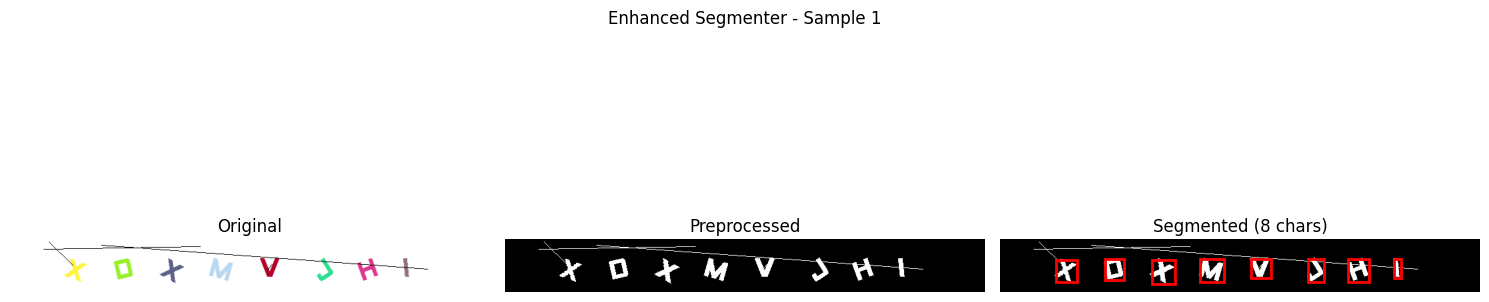


--- Sample 2 (Image 1) ---
True label: 2zimhl0
Expected characters: 7
Detected segments: 7
Character boxes: [(122, 38, 144, 64), (189, 39, 201, 66), (244, 40, 258, 54), (294, 41, 324, 69), (362, 28, 384, 67), (421, 28, 443, 59), (471, 36, 494, 63)]


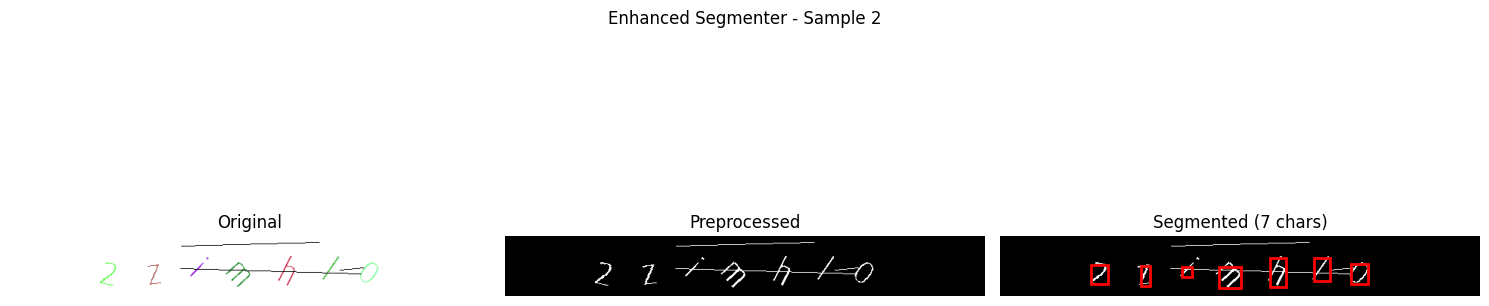


--- Sample 3 (Image 2) ---
True label: s2he
Expected characters: 4
Detected segments: 4
Character boxes: [(99, 41, 114, 63), (127, 39, 144, 62), (156, 37, 175, 62), (212, 42, 228, 60)]


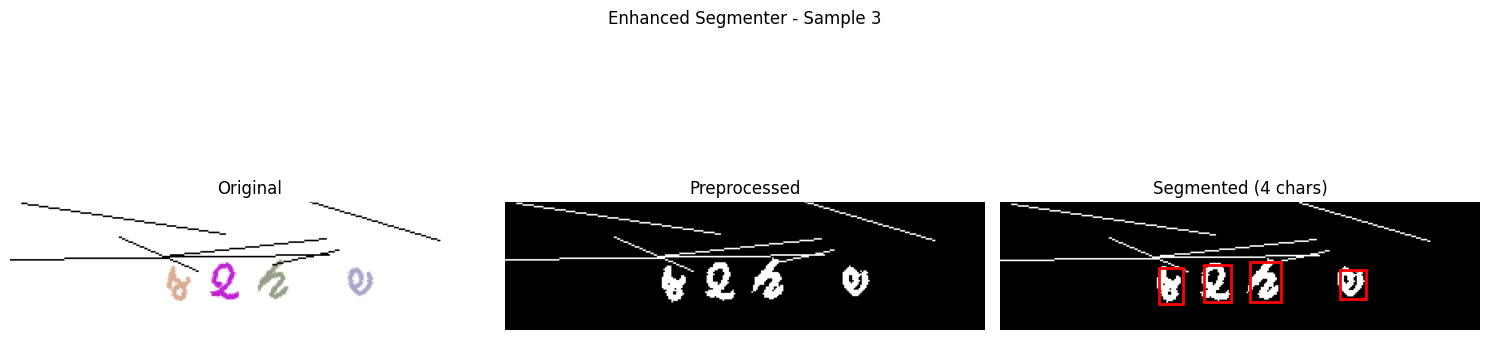


--- Sample 4 (Image 3) ---
True label: stx1upye
Expected characters: 8
Detected segments: 2
Character boxes: [(300, 39, 304, 53), (337, 35, 351, 41)]


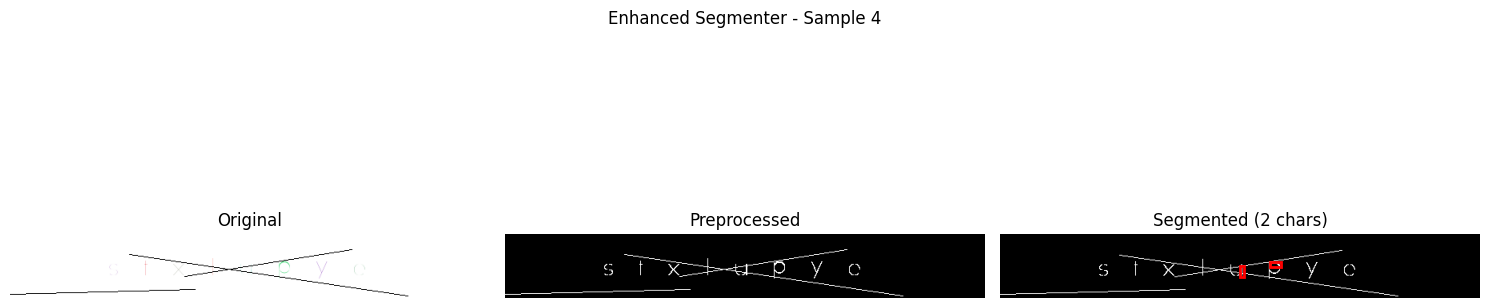


--- Sample 5 (Image 4) ---
True label: upho6mjh
Expected characters: 8
Detected segments: 8
Character boxes: [(100, 40, 122, 64), (133, 37, 150, 68), (177, 37, 206, 63), (220, 40, 239, 63), (247, 34, 268, 64), (285, 41, 312, 65), (342, 29, 359, 67), (369, 35, 390, 65)]


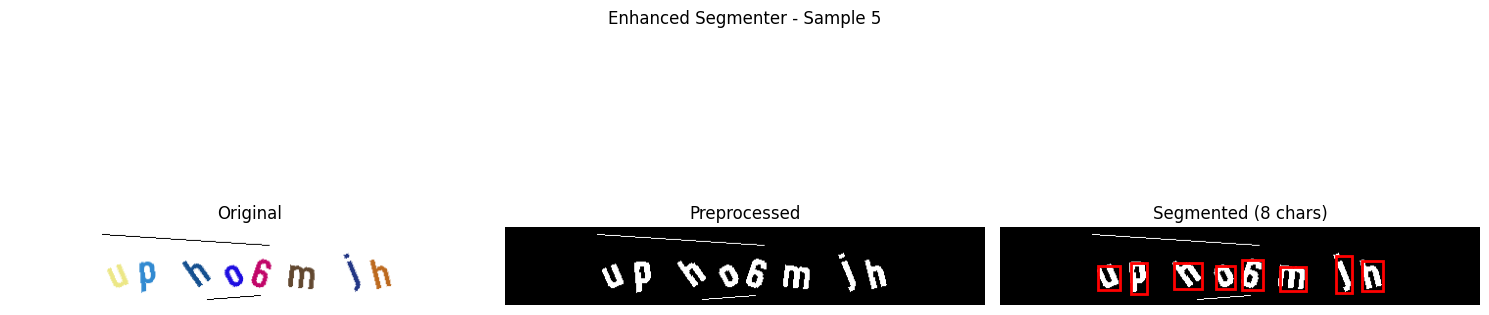


--- Sample 6 (Image 10) ---
True label: 4rcb
Expected characters: 4
Detected segments: 4
Character boxes: [(142, 34, 151, 50), (188, 39, 201, 50), (220, 39, 233, 49), (259, np.int64(37), 279, np.int64(53))]


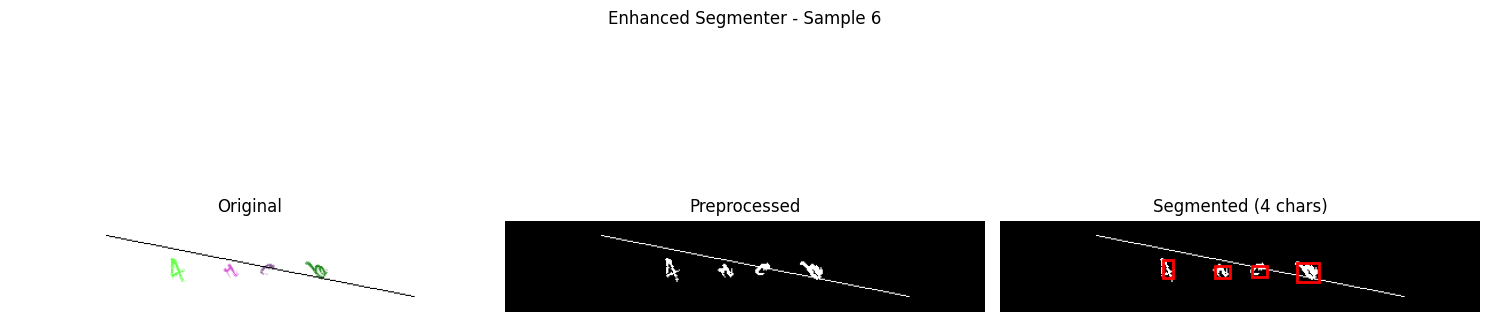


--- Sample 7 (Image 20) ---
True label: aswhu3
Expected characters: 6
Detected segments: 6
Character boxes: [(89, 33, 119, 69), (162, 30, 187, 64), (228, 28, 268, 70), (302, 28, 343, 70), (372, 28, 408, 66), (437, 26, 467, 65)]


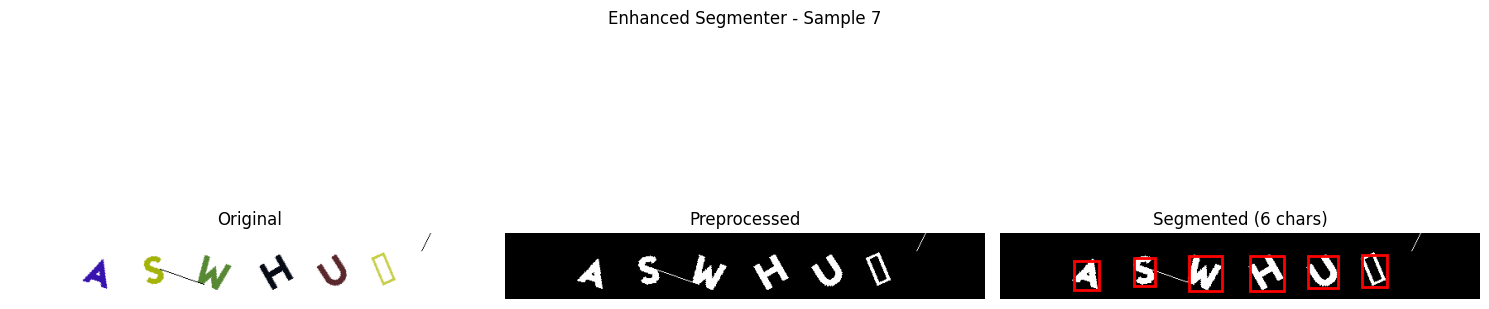


--- Sample 8 (Image 50) ---
True label: qhxd00p
Expected characters: 7
Detected segments: 7
Character boxes: [(140, 35, 160, 61), (199, np.int64(33), 224, np.int64(59)), (262, 33, 278, 61), (321, 33, 337, 59), (382, 27, 400, 60), (447, 27, 466, 60), (504, 33, 523, 59)]


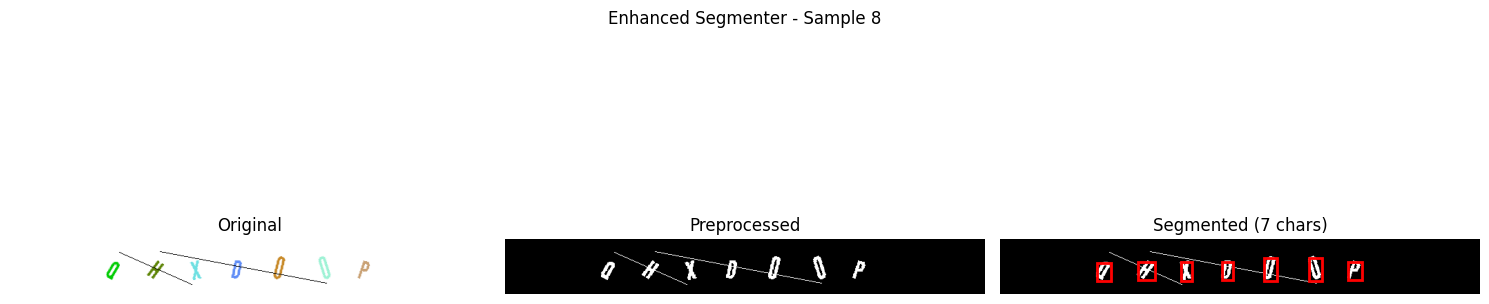


--- Sample 9 (Image 100) ---
True label: legbzjng
Expected characters: 8
Detected segments: 8
Character boxes: [(128, 28, 137, 52), (168, 28, 176, 52), (207, 28, 216, 53), (246, 28, 255, 52), (284, 28, 294, 52), (325, 28, 334, 52), (365, 28, 375, 52), (405, 28, 414, 53)]


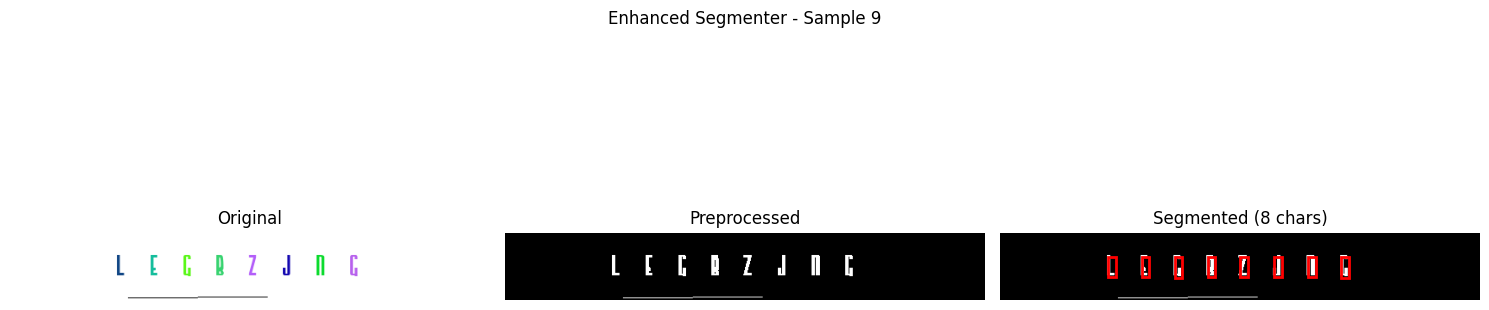


--- Sample 10 (Image 200) ---
True label: afjdde
Expected characters: 6
Detected segments: 5
Character boxes: [(129, 29, 147, 55), (185, 29, 199, 56), (235, 27, 250, 53), (341, 27, 357, 53), (394, 27, 408, 53)]


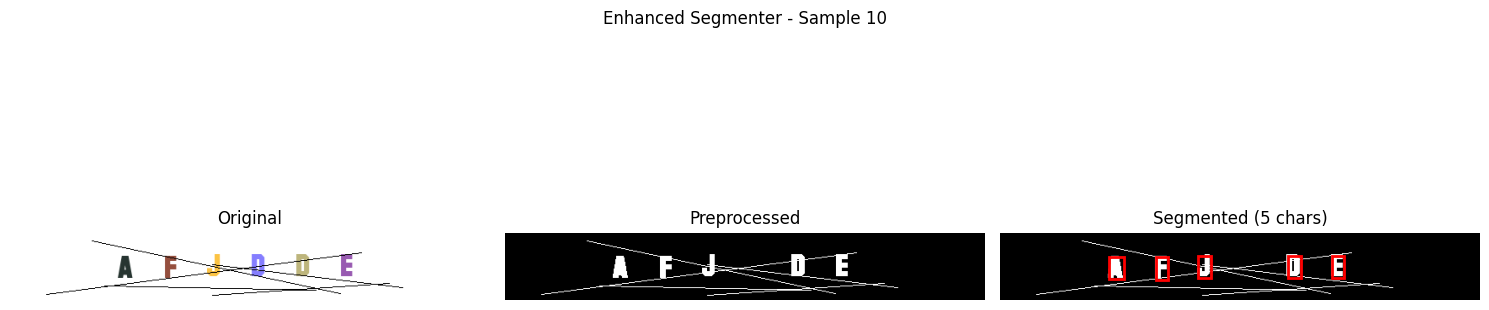


--- Sample 11 (Image 300) ---
True label: kno8n6i
Expected characters: 7
Detected segments: 7
Character boxes: [(97, 35, 115, 58), (138, 37, 157, 58), (180, 37, 198, 58), (222, 27, 243, 59), (266, 36, 285, 58), (308, 27, 329, 58), (352, 37, 358, 58)]


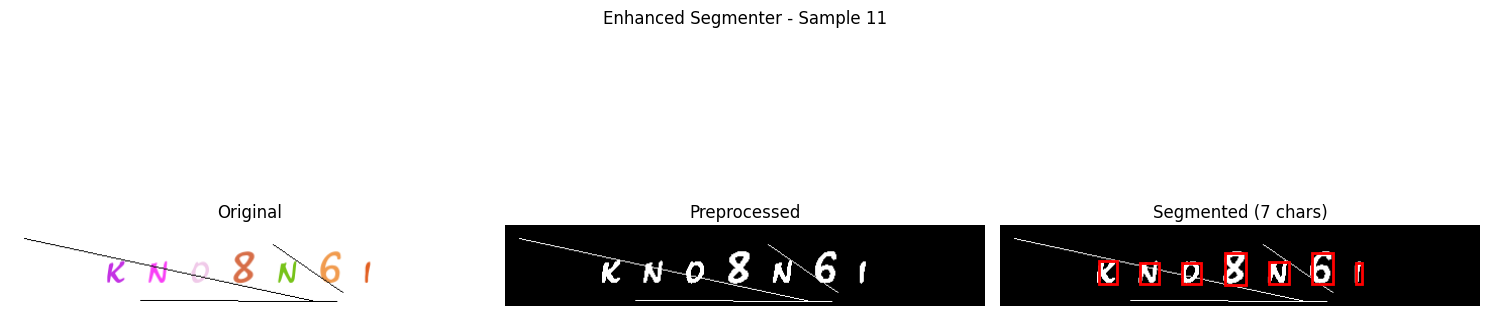


--- Sample 12 (Image 400) ---
True label: ke96ccvs
Expected characters: 8
Detected segments: 8
Character boxes: [(129, 30, 142, 59), (181, 38, 194, 59), (233, 30, 246, 59), (285, 30, 298, 59), (337, 38, 350, 59), (389, 38, 402, 59), (441, 38, 454, 59), (492, 37, 505, 58)]


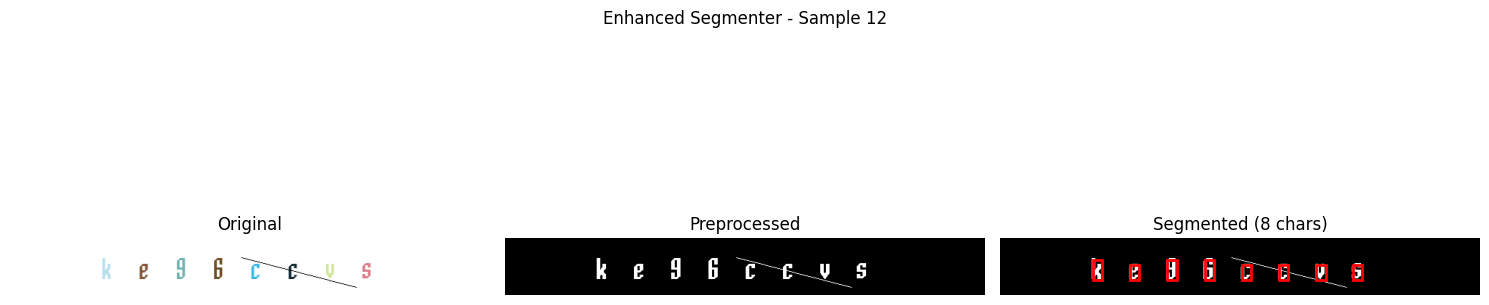


--- Sample 13 (Image 500) ---
True label: yf1skt
Expected characters: 6
Detected segments: 5
Character boxes: [(131, 33, 152, 59), (207, 36, 230, 56), (350, 34, 373, 50), (428, 32, 449, 51), (500, 34, 524, 51)]


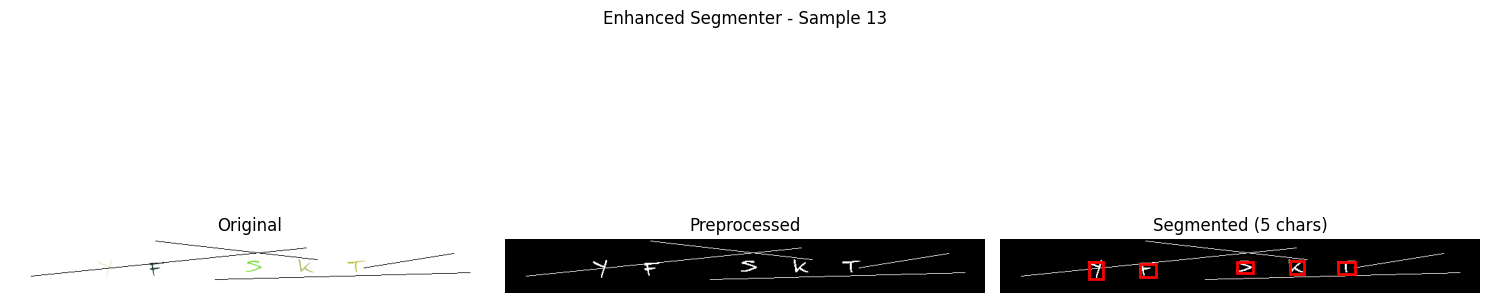


--- Sample 14 (Image 600) ---
True label: 2nnn
Expected characters: 4
Detected segments: 3
Character boxes: [(69, 29, 99, 58), (107, 36, 120, 58), (126, 36, 139, 58)]


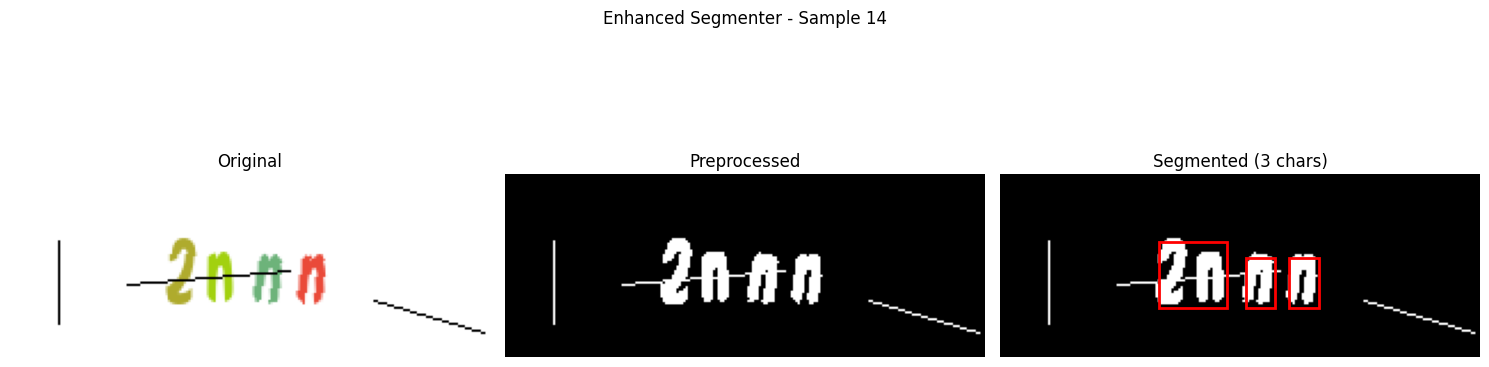


--- Sample 15 (Image 700) ---
True label: xdwmowd
Expected characters: 7
Detected segments: 7
Character boxes: [(111, 34, 128, 52), (134, 35, 149, 55), (159, 35, 178, 56), (189, 36, 205, 58), (215, 34, 230, 54), (241, 36, 255, 57), (272, 36, 287, 55)]


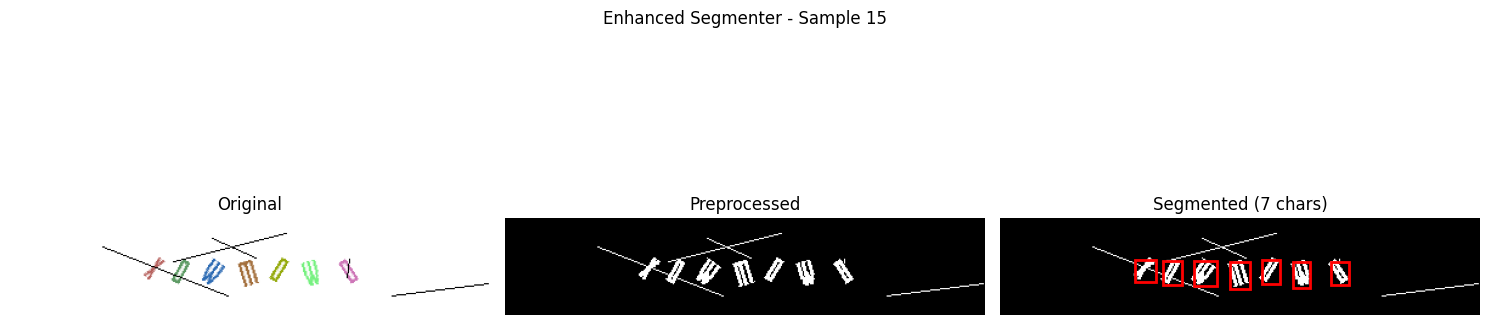


--- Sample 16 (Image 800) ---
True label: al7qec9
Expected characters: 7
Detected segments: 4
Character boxes: [(96, 35, 126, 60), (138, 36, 157, 58), (172, 39, 208, 60), (230, 38, 265, 58)]


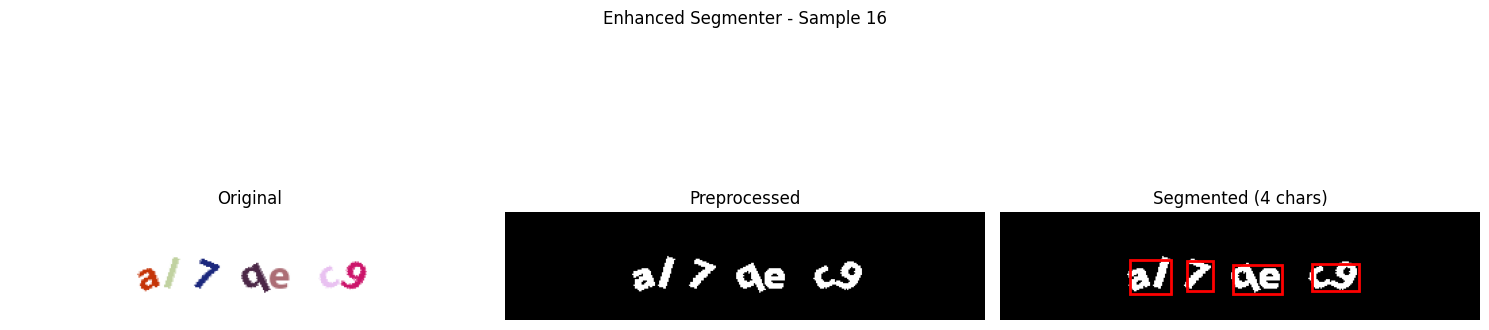


--- Sample 17 (Image 900) ---
True label: nx7a9l
Expected characters: 6
Detected segments: 6
Character boxes: [(163, 40, 181, 61), (240, 39, 263, 62), (302, 36, 315, 60), (366, 39, 382, 61), (430, 36, 449, 58), (498, 35, 507, 59)]


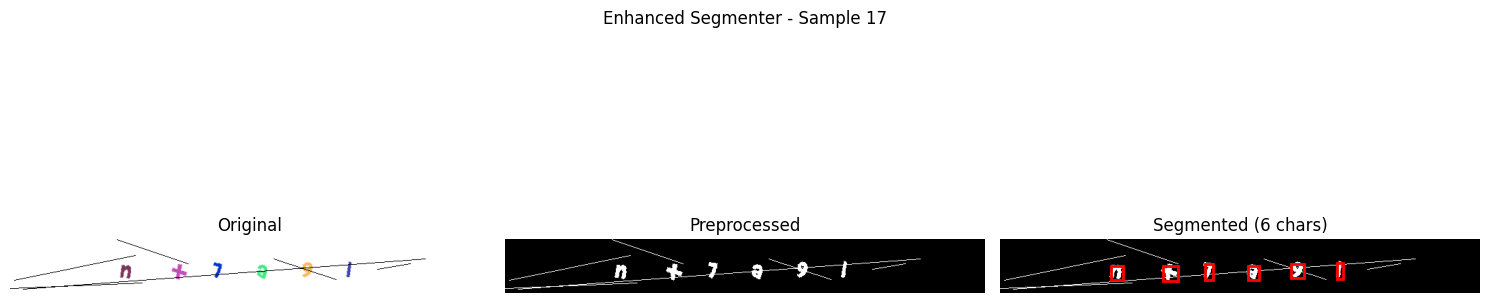


--- Sample 18 (Image 1000) ---
True label: uli3u0
Expected characters: 6
Detected segments: 6
Character boxes: [(112, 29, 129, 54), (158, 29, 170, 54), (198, 29, 202, 54), (231, 29, 246, 54), (275, 29, 292, 54), (320, 29, 343, 54)]


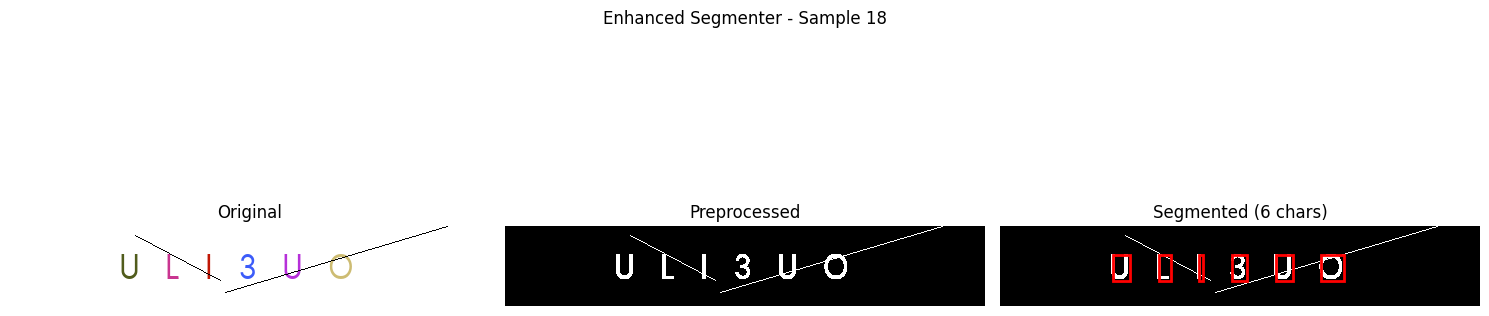


Processed 18 sample images

SEGMENTATION STATISTICS
Total processed: 18
Skeleton-based splits: 1
Histogram-based splits: 0
Shape-guided splits: 1
Standard CCA (no split): 112


In [31]:
# ============================================================================
# ENHANCED CAPTCHA SEGMENTER EVALUATION
# ============================================================================

print("="*80)
print("ENHANCED CAPTCHA SEGMENTER - PERFORMANCE EVALUATION")
print("="*80)

# Initialize the EnhancedCaptchaSegmenter
enhanced_segmenter = EnhancedCAPTCHASegmenter(debug=True)

# Test on a sample of processed images
print("\nTesting EnhancedCaptchaSegmenter on sample images...")

# Select diverse test samples
test_indices = [0, 1, 2, 3, 4, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
sample_results = []

for i, idx in enumerate(test_indices):
    if idx < len(processed_images):
        print(f"\n--- Sample {i+1} (Image {idx}) ---")
        print(f"True label: {train_labels[idx]}")
        
        # Get processed image
        processed_img = processed_images[idx]
        
        # Segment with EnhancedCaptchaSegmenter
        char_boxes = enhanced_segmenter.segment(
            processed_img,
            expected_chars=len(train_labels[idx]),
            min_char_width=3,
            max_char_width=None,
            min_char_height=5
        )
        
        print(f"Expected characters: {len(train_labels[idx])}")
        print(f"Detected segments: {len(char_boxes)}")
        print(f"Character boxes: {char_boxes}")
        
        # Store results
        sample_results.append({
            'index': idx,
            'true_label': train_labels[idx],
            'expected_chars': len(train_labels[idx]),
            'detected_segments': len(char_boxes),
            'char_boxes': char_boxes,
            'processed_img': processed_img,
            'original_img': train_images[idx]
        })
        
        # Visualize segmentation
        enhanced_segmenter.visualize_segmentation(
            train_images[idx], 
            processed_img, 
            char_boxes, 
            title=f"Enhanced Segmenter - Sample {i+1}"
        )

print(f"\nProcessed {len(sample_results)} sample images")
enhanced_segmenter.print_stats()

In [35]:
"""
ENHANCED DATASET EVALUATION FUNCTION
Works with entire dataset or sample_results
"""

def calculate_segmentation_accuracy(sample_results=None, segmenter=None, 
                                   images=None, labels=None, preprocessor=None,
                                   sample_size=None):
    """
    Calculate segmentation accuracy from either:
    1. Existing sample_results (if provided), OR
    2. Full dataset evaluation (if segmenter, images, labels provided)
    
    Args:
        sample_results: List of result dicts (optional)
        segmenter: Segmenter instance (optional, for full dataset eval)
        images: List of images (optional, for full dataset eval)
        labels: List of labels (optional, for full dataset eval)
        preprocessor: Preprocessor instance (optional)
        sample_size: Number of samples to evaluate (None = all)
    
    Returns:
        dict containing:
            - 'accuracy_percentage': float (0-100)
            - 'correct_count': int
            - 'total_count': int
            - 'under_segmented': int
            - 'over_segmented': int
            - 'detailed_results': list of dicts
    """
    
    # ========================================================================
    # OPTION 1: Use existing sample_results
    # ========================================================================
    if sample_results is not None:
        print(f"Evaluating from existing {len(sample_results)} results...")
        results_to_analyze = sample_results
    
    # ========================================================================
    # OPTION 2: Evaluate full dataset
    # ========================================================================
    elif segmenter is not None and images is not None and labels is not None:
        print("Running segmentation on dataset...")
        
        # Determine sample size
        n_samples = len(images) if sample_size is None else min(sample_size, len(images))
        print(f"Evaluating on {n_samples} images...")
        
        # Run segmentation on each image
        results_to_analyze = []
        
        for i in range(n_samples):
            # Preprocess if needed
            if preprocessor is not None:
                processed_img = preprocessor.preprocess(images[i])
            else:
                # Assume images are already processed
                processed_img = images[i]
            
            # Segment
            char_boxes = segmenter.segment(
                processed_img,
                expected_chars=len(labels[i]),
                min_char_width=3,
                max_char_width=None,
                min_char_height=5
            )
            
            # Store result
            results_to_analyze.append({
                'index': i,
                'true_label': labels[i],
                'expected_chars': len(labels[i]),
                'detected_segments': len(char_boxes),
                'char_boxes': char_boxes
            })
            
            # Progress update every 100 images
            if (i + 1) % 100 == 0:
                current_correct = sum(1 for r in results_to_analyze 
                                     if r['expected_chars'] == r['detected_segments'])
                current_acc = 100 * current_correct / (i + 1)
                print(f"  Progress: {i+1}/{n_samples} - Current accuracy: {current_acc:.1f}%")
    
    else:
        print("⚠️  Error: Must provide either sample_results OR (segmenter + images + labels)")
        return {
            'accuracy_percentage': 0.0,
            'correct_count': 0,
            'total_count': 0,
            'under_segmented': 0,
            'over_segmented': 0,
            'detailed_results': []
        }
    
    # ========================================================================
    # ANALYZE RESULTS
    # ========================================================================
    
    if not results_to_analyze:
        print("⚠️  No results to analyze!")
        return {
            'accuracy_percentage': 0.0,
            'correct_count': 0,
            'total_count': 0,
            'under_segmented': 0,
            'over_segmented': 0,
            'detailed_results': []
        }
    
    # Analyze each result
    correct_count = 0
    under_segmented = 0
    over_segmented = 0
    detailed_results = []
    
    for i, result in enumerate(results_to_analyze):
        expected = result['expected_chars']
        detected = result['detected_segments']
        
        # Determine if correct
        is_correct = (expected == detected)
        
        # Categorize error type
        if is_correct:
            correct_count += 1
            error_type = 'correct'
        elif detected < expected:
            under_segmented += 1
            error_type = 'under'
        else:  # detected > expected
            over_segmented += 1
            error_type = 'over'
        
        # Store detailed info
        detailed_results.append({
            'index': result.get('index', i),
            'label': result.get('true_label', 'unknown'),
            'expected': expected,
            'detected': detected,
            'error': abs(detected - expected),
            'error_type': error_type,
            'is_correct': is_correct
        })
    
    # Calculate overall accuracy
    total_count = len(results_to_analyze)
    accuracy_percentage = 100.0 * correct_count / total_count
    
    # ========================================================================
    # PRINT SUMMARY
    # ========================================================================
    
    print("\n" + "=" * 80)
    print("SEGMENTATION ACCURACY REPORT")
    print("=" * 80)
    print(f"\nTotal samples evaluated: {total_count}")
    print(f"Correctly segmented: {correct_count}")
    print(f"Incorrectly segmented: {total_count - correct_count}")
    print(f"\n{'=' * 80}")
    print(f"ACCURACY: {accuracy_percentage:.2f}%")
    print(f"{'=' * 80}")
    
    print(f"\nError Breakdown:")
    print(f"  ✓ Correct: {correct_count} ({100*correct_count/total_count:.1f}%)")
    print(f"  ⬇️  Under-segmented: {under_segmented} ({100*under_segmented/total_count:.1f}%)")
    print(f"  ⬆️  Over-segmented: {over_segmented} ({100*over_segmented/total_count:.1f}%)")
    
    # ========================================================================
    # SHOW WORST FAILURES
    # ========================================================================
    
    failures = [r for r in detailed_results if not r['is_correct']]
    if failures:
        failures_sorted = sorted(failures, key=lambda x: x['error'], reverse=True)
        
        print(f"\n{'=' * 80}")
        print(f"TOP {min(10, len(failures))} WORST FAILURES")
        print(f"{'=' * 80}")
        print(f"\n{'Rank':<6} {'Label':<15} {'Expected':<10} {'Detected':<10} {'Error':<8} {'Type':<10}")
        print("-" * 80)
        
        for rank, case in enumerate(failures_sorted[:10], 1):
            print(f"{rank:<6} {case['label']:<15} {case['expected']:<10} "
                  f"{case['detected']:<10} {case['error']:<8} {case['error_type']:<10}")
    else:
        print(f"\n🎉 NO FAILURES - All {total_count} segmentations correct!")
    
    # ========================================================================
    # ADDITIONAL STATISTICS
    # ========================================================================
    
    # Error distribution
    errors = [r['error'] for r in detailed_results]
    if errors and max(errors) > 0:
        print(f"\n{'=' * 80}")
        print("ERROR DISTRIBUTION")
        print(f"{'=' * 80}")
        print(f"Average error: {sum(errors)/len(errors):.2f} characters")
        print(f"Maximum error: {max(errors)} characters")
        
        # Error histogram
        from collections import Counter
        error_counts = Counter(errors)
        print(f"\nError frequency:")
        for error_val in sorted(error_counts.keys()):
            count = error_counts[error_val]
            percentage = 100 * count / total_count
            bar = '█' * int(percentage / 2)  # Visual bar
            print(f"  Error {error_val}: {count:4d} ({percentage:5.1f}%) {bar}")
    
    # Label length analysis
    print(f"\n{'=' * 80}")
    print("ACCURACY BY LABEL LENGTH")
    print(f"{'=' * 80}")
    
    from collections import defaultdict
    by_length = defaultdict(lambda: {'total': 0, 'correct': 0})
    
    for result in detailed_results:
        length = result['expected']
        by_length[length]['total'] += 1
        if result['is_correct']:
            by_length[length]['correct'] += 1
    
    print(f"\n{'Length':<8} {'Total':<8} {'Correct':<10} {'Accuracy':<10}")
    print("-" * 40)
    for length in sorted(by_length.keys()):
        stats = by_length[length]
        length_acc = 100 * stats['correct'] / stats['total']
        print(f"{length:<8} {stats['total']:<8} {stats['correct']:<10} {length_acc:<10.1f}%")
    
    print("=" * 80 + "\n")
    
    # ========================================================================
    # RETURN RESULTS
    # ========================================================================
    
    return {
        'accuracy_percentage': accuracy_percentage,
        'correct_count': correct_count,
        'total_count': total_count,
        'under_segmented': under_segmented,
        'over_segmented': over_segmented,
        'detailed_results': detailed_results,
        'failures': failures if failures else [],
        'by_length': dict(by_length)
    }


# ============================================================================
# USAGE EXAMPLES
# ============================================================================

# Example 1: Use with existing sample_results
results = calculate_segmentation_accuracy(sample_results=sample_results)

# Example 2: Evaluate entire training dataset
results = calculate_segmentation_accuracy(
    segmenter=enhanced_segmenter,
    images=train_images,
    labels=train_labels,
    preprocessor=preprocessor,
    sample_size=None  # Use all images
)

# Example 3: Evaluate on subset of data
results = calculate_segmentation_accuracy(
    segmenter=enhanced_segmenter,
    images=train_images,
    labels=train_labels,
    preprocessor=preprocessor,
    sample_size=500  # Evaluate first 500 images
)

# Example 4: Evaluate test set
results = calculate_segmentation_accuracy(
    segmenter=enhanced_segmenter,
    images=test_images,
    labels=test_labels,
    preprocessor=preprocessor
)

# Access results
print(f"✅ Final Accuracy: {results['accuracy_percentage']:.2f}%")
print(f"Correct: {results['correct_count']}/{results['total_count']}")
print(f"Under-segmented: {results['under_segmented']}")
print(f"Over-segmented: {results['over_segmented']}")

# Get failures for further analysis
failures = results['failures']
for failure in failures[:5]:
    print(f"Failed: {failure['label']} - Expected {failure['expected']}, Got {failure['detected']}")

# Check accuracy by label length
by_length = results['by_length']
for length, stats in sorted(by_length.items()):
    acc = 100 * stats['correct'] / stats['total']
    print(f"{length}-char labels: {acc:.1f}% accuracy")

Evaluating from existing 18 results...

SEGMENTATION ACCURACY REPORT

Total samples evaluated: 18
Correctly segmented: 13
Incorrectly segmented: 5

ACCURACY: 72.22%

Error Breakdown:
  ✓ Correct: 13 (72.2%)
  ⬇️  Under-segmented: 5 (27.8%)
  ⬆️  Over-segmented: 0 (0.0%)

TOP 5 WORST FAILURES

Rank   Label           Expected   Detected   Error    Type      
--------------------------------------------------------------------------------
1      stx1upye        8          2          6        under     
2      al7qec9         7          4          3        under     
3      afjdde          6          5          1        under     
4      yf1skt          6          5          1        under     
5      2nnn            4          3          1        under     

ERROR DISTRIBUTION
Average error: 0.67 characters
Maximum error: 6 characters

Error frequency:
  Error 0:   13 ( 72.2%) ████████████████████████████████████
  Error 1:    3 ( 16.7%) ████████
  Error 3:    1 (  5.6%) ██
  Error 6:    


Extracting character data from ALL training images...

Extracted 44758 character images from 8010 CAPTCHA images
Sample character labels: ['x', 'd', 'x', 'm', 'v', 'j', 'h', 'i', '2', 'z']


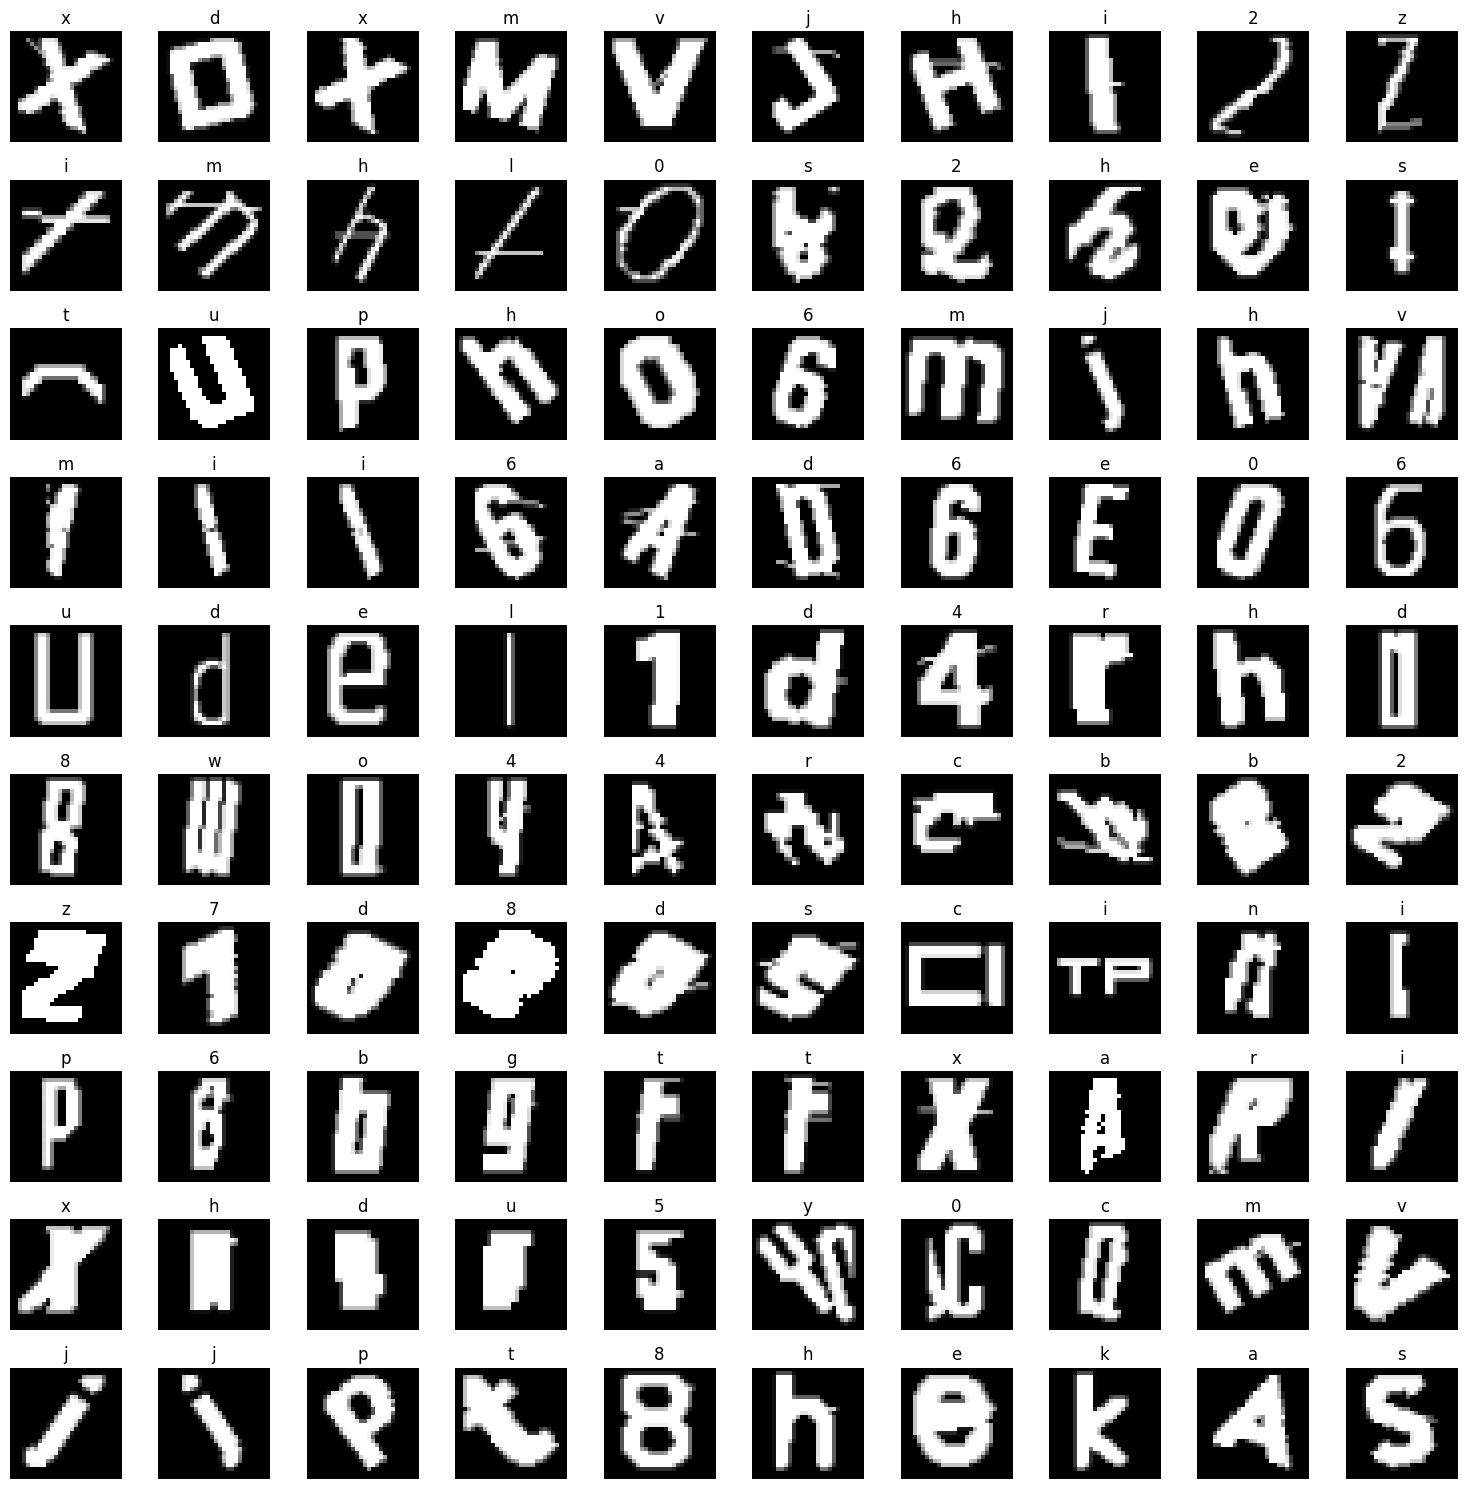

In [36]:
# Step 3: Improved CNN Classifier with more capacity
class TinyCNN(nn.Module):
    """Improved CNN for character classification with residual connections"""
    def __init__(self, num_classes=36):
        super(TinyCNN, self).__init__()
        
        # Conv Block 1 (28x28 -> 14x14)
        self.conv1a = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Conv Block 2 (14x14 -> 7x7)
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Conv Block 3 (7x7 -> 3x3)
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers with more capacity
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Block 1 with residual
        identity = x
        x = self.relu(self.bn1a(self.conv1a(x)))
        x = self.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        
        # Block 2 with residual
        x = self.relu(self.bn2a(self.conv2a(x)))
        x = self.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        
        # Block 3 with residual
        x = self.relu(self.bn3a(self.conv3a(x)))
        x = self.relu(self.bn3b(self.conv3b(x)))
        x = self.pool3(x)
        
        # Flatten and FC layers
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

# Character dataset class
class CharacterDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
        # Create character to index mapping
        all_chars = set()
        for label in labels:
            all_chars.update(label)
        
        self.char_to_idx = {char: idx for idx, char in enumerate(sorted(all_chars))}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.num_classes = len(self.char_to_idx)
        
        print(f"Found {self.num_classes} unique characters: {sorted(all_chars)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data preparation for character classification
def prepare_character_data(images, labels, preprocessor, segmenter):
    """Extract individual characters from CAPTCHA images - IMPROVED v2 with aspect ratio preservation"""
    char_images = []
    char_labels = []
    
    for img, label in zip(images, labels):
        # Preprocess
        processed = preprocessor.preprocess(img)
        
        # Segment with balanced parameters
        char_boxes = segmenter.segment(
            processed, 
            expected_chars=len(label),
            min_char_width=3,
            max_char_width=None,
            min_char_height=5,
        )
        
        # Extract character crops with IMPROVED aspect ratio preservation
        for i, box in enumerate(char_boxes):
            x1, y1, x2, y2 = box
            char_crop = processed[y1:y2, x1:x2]
            
            if char_crop.size == 0:
                continue
            
            # IMPROVED: Preserve aspect ratio by padding to square first
            h, w = char_crop.shape
            max_dim = max(h, w)
            
            # Create square canvas
            square = np.zeros((max_dim, max_dim), dtype=np.uint8)
            
            # Center the character in the square
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2
            square[y_offset:y_offset+h, x_offset:x_offset+w] = char_crop
            
            # Add border padding (10% of size)
            border = max(2, int(max_dim * 0.1))
            square_padded = cv2.copyMakeBorder(
                square, border, border, border, border,
                cv2.BORDER_CONSTANT, value=0
            )
            
            # Now resize to 28x28 (maintains aspect ratio since it's square)
            char_resized = cv2.resize(square_padded, (28, 28), interpolation=cv2.INTER_AREA)
            
            # Normalize
            char_normalized = char_resized.astype(np.float32) / 255.0
            
            char_images.append(char_normalized)
            
            # Get corresponding label character
            if i < len(label):
                char_labels.append(label[i])
            else:
                char_labels.append('?')  # Unknown character
    
    return np.array(char_images), char_labels

# Prepare character data from ALL training images
print("\n" + "="*60)
print("Extracting character data from ALL training images...")
print("="*60)

char_images, char_labels = prepare_character_data(
    train_images, train_labels_cleaned, preprocessor, segmenter
)

print(f"\nExtracted {len(char_images)} character images from {len(train_images)} CAPTCHA images")
print(f"Sample character labels: {char_labels[:10]}")

# Display sample characters
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    if i < len(char_images):
        row = i // 10
        col = i % 10
        axes[row, col].imshow(char_images[i], cmap='gray')
        axes[row, col].set_title(char_labels[i])
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()



Training character classifier on all character data...
Found 37 unique characters: ['(', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Epoch 1/10: Train Loss: 2.2604, Train Acc: 51.81%, Val Acc: 62.65%
Epoch 2/10: Train Loss: 1.9358, Train Acc: 62.75%, Val Acc: 67.35%
Epoch 3/10: Train Loss: 1.8407, Train Acc: 66.05%, Val Acc: 67.92%
Epoch 4/10: Train Loss: 1.7785, Train Acc: 67.89%, Val Acc: 69.73%
Epoch 5/10: Train Loss: 1.7285, Train Acc: 69.58%, Val Acc: 70.52%
Epoch 6/10: Train Loss: 1.6844, Train Acc: 70.95%, Val Acc: 71.30%
Epoch 7/10: Train Loss: 1.6379, Train Acc: 72.45%, Val Acc: 71.94%
Epoch 8/10: Train Loss: 1.6003, Train Acc: 73.35%, Val Acc: 71.77%
Epoch 9/10: Train Loss: 1.5691, Train Acc: 74.52%, Val Acc: 72.26%
Epoch 10/10: Train Loss: 1.5304, Train Acc: 75.59%, Val Acc: 72.50%


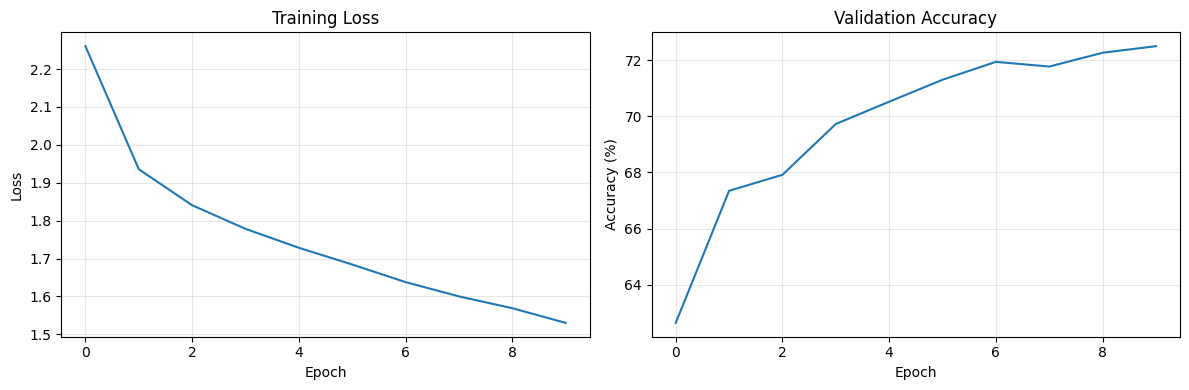


Final Training Loss: 1.5304
Final Validation Accuracy: 72.50%


In [25]:
# IMPROVED Training with Data Augmentation and Better Optimization
class DataAugmentation:
    """Simple data augmentation for character images"""
    def __init__(self, rotation_range=10, noise_std=0.05):
        self.rotation_range = rotation_range
        self.noise_std = noise_std
    
    def __call__(self, img):
        """Apply random augmentations to image tensor"""
        # img is already a tensor [1, 28, 28]
        
        # Random rotation
        if np.random.random() > 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            img_np = img.squeeze().numpy()
            center = (14, 14)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img_np = cv2.warpAffine(img_np, M, (28, 28), borderValue=0)
            img = torch.from_numpy(img_np).unsqueeze(0)
        
        # Random noise
        if np.random.random() > 0.5:
            noise = torch.randn_like(img) * self.noise_std
            img = img + noise
            img = torch.clamp(img, 0, 1)
        
        return img


# Training the character classifier - IMPROVED VERSION
def train_character_classifier(char_images, char_labels, num_epochs=20, batch_size=32):
    """Train the CNN with data augmentation and improved optimization"""

    # Create dataset
    dataset = CharacterDataset(char_images, char_labels)

    # Split data
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create data loaders
    # FIXED: drop_last=True to avoid BatchNorm error with single-sample batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Initialize model
    model = TinyCNN(num_classes=dataset.num_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # IMPROVED: Label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # IMPROVED: AdamW optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # IMPROVED: ReduceLROnPlateau scheduler (better than StepLR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3  # Removed verbose (not supported)
    )

    # Data augmentation
    augment = DataAugmentation(rotation_range=10, noise_std=0.05)

    # Training loop
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0
    early_stop_patience = 8

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1).float().to(device)
            
            # Apply data augmentation during training
            if epoch > 0:  # Skip first epoch for faster initial convergence
                augmented_batch = []
                for img in data:
                    augmented_batch.append(augment(img))
                data = torch.stack(augmented_batch)
            
            target = torch.tensor([dataset.char_to_idx.get(char, 0) for char in target]).to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # IMPROVED: Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = data.unsqueeze(1).float().to(device)
                target = torch.tensor([dataset.char_to_idx.get(char, 0) for char in target]).to(device)

                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}%")
            break

    return model, dataset, train_losses, val_accuracies

# Train the model with more epochs and proper batch size
print("\n" + "="*60)
print("Training character classifier on all character data...")
print("="*60)

model, char_dataset, train_losses, val_accuracies = train_character_classifier(
    char_images, char_labels, num_epochs=10, batch_size=64  # Increased to 50 epochs
)

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(val_accuracies)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [26]:
# Complete CAPTCHA Prediction Pipeline
class CAPTCHAPredictor:
    def __init__(self, model, char_dataset, preprocessor, segmenter, device=None):
        self.model = model
        self.char_dataset = char_dataset
        self.preprocessor = preprocessor
        self.segmenter = segmenter
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
    
    def predict_captcha(self, image):
        """Predict the full CAPTCHA text from an image"""
        # Step 1: Preprocess
        processed = self.preprocessor.preprocess(image)
        
        # Step 2: Segment characters with balanced parameters
        char_boxes = self.segmenter.segment(
            processed,
            expected_chars=None,  # Don't assume length
            min_char_width=3,
            max_char_width=None,
            min_char_height=5,
        )
        
        # Step 3: Extract and classify each character with IMPROVED aspect ratio preservation
        predicted_chars = []
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            
            # Extract character
            char_crop = processed[y1:y2, x1:x2]
            
            if char_crop.size == 0:
                continue
            
            # IMPROVED: Preserve aspect ratio by padding to square first
            h, w = char_crop.shape
            max_dim = max(h, w)
            
            # Create square canvas
            square = np.zeros((max_dim, max_dim), dtype=np.uint8)
            
            # Center the character in the square
            y_offset = (max_dim - h) // 2
            x_offset = (max_dim - w) // 2
            square[y_offset:y_offset+h, x_offset:x_offset+w] = char_crop
            
            # Add border padding (10% of size)
            border = max(2, int(max_dim * 0.1))
            square_padded = cv2.copyMakeBorder(
                square, border, border, border, border,
                cv2.BORDER_CONSTANT, value=0
            )
            
            # Now resize to 28x28
            char_resized = cv2.resize(square_padded, (28, 28), interpolation=cv2.INTER_AREA)
            
            # Normalize
            char_normalized = char_resized.astype(np.float32) / 255.0
            
            # Convert to tensor
            char_tensor = torch.from_numpy(char_normalized).unsqueeze(0).unsqueeze(0).to(self.device)
            
            # Predict
            with torch.no_grad():
                output = self.model(char_tensor)
                _, predicted_idx = torch.max(output.data, 1)
                predicted_char = self.char_dataset.idx_to_char[predicted_idx.item()]
                predicted_chars.append(predicted_char)
        
        # Join characters into string
        predicted_text = ''.join(predicted_chars)
        
        return predicted_text, char_boxes
    
    def visualize_prediction(self, image, predicted_text, true_label, char_boxes):
        """Visualize the prediction result"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original image
        if len(image.shape) == 3:
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(image, cmap='gray')
        axes[0].set_title(f"True: {true_label}")
        axes[0].axis('off')
        
        # Prediction with boxes
        processed = self.preprocessor.preprocess(image)
        axes[1].imshow(processed, cmap='gray')
        axes[1].set_title(f"Predicted: {predicted_text}")
        
        for box in char_boxes:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[1].add_patch(rect)
        
        axes[1].axis('off')
        
        # Color code the title based on correctness
        if predicted_text == true_label:
            axes[1].title.set_color('green')
        else:
            axes[1].title.set_color('red')
        
        plt.tight_layout()
        plt.show()

# Initialize predictor
print("\n" + "="*60)
print("Initializing CAPTCHA Predictor...")
print("="*60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = CAPTCHAPredictor(model, char_dataset, preprocessor, segmenter, device)

print(f"Using device: {device}")
print("Predictor ready!")



Initializing CAPTCHA Predictor...
Using device: cpu
Predictor ready!



Testing predictor on sample images...

--- Sample 1 ---
True Label:      845ios
Predicted Text:  845ie6
Match: False


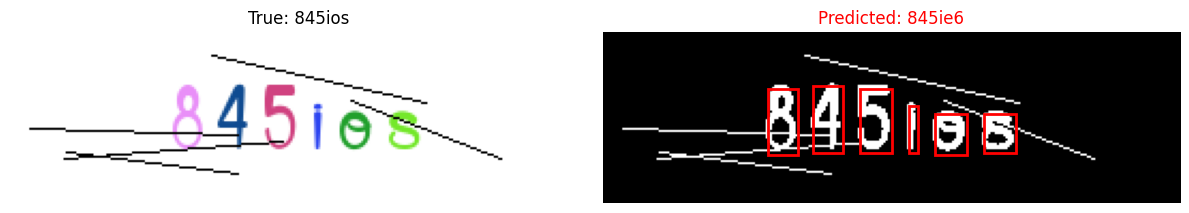


--- Sample 2 ---
True Label:      kjlcnst
Predicted Text:  xjlcnst
Match: False


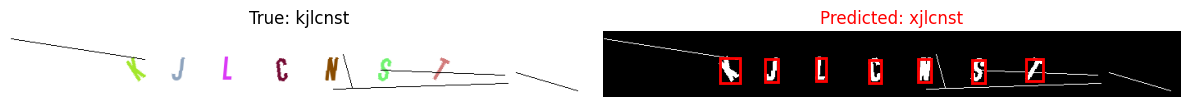


--- Sample 3 ---
True Label:      hc0ulqk
Predicted Text:  2y
Match: False


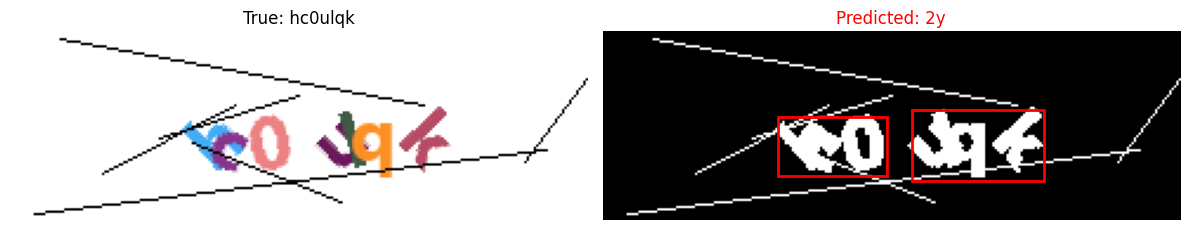


--- Sample 4 ---
True Label:      s29j
Predicted Text:  s229j
Match: False


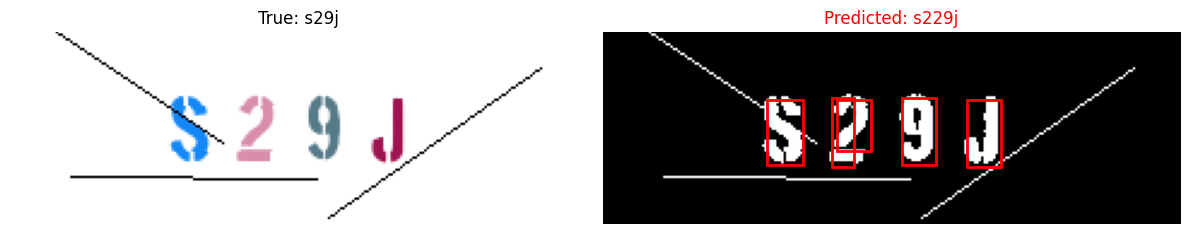


--- Sample 5 ---
True Label:      xzrf2
Predicted Text:  xr
Match: False


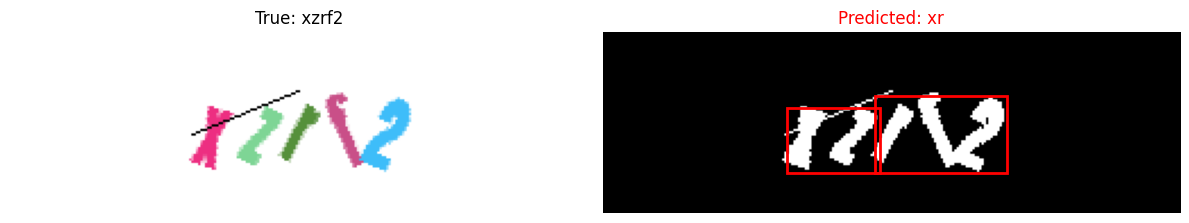


Evaluating on FULL test set...
Processing 2000 test images...
Progress: 0/2000 (0.0%)
Progress: 100/2000 (5.0%)
Progress: 200/2000 (10.0%)
Progress: 300/2000 (15.0%)
Progress: 400/2000 (20.0%)
Progress: 500/2000 (25.0%)
Progress: 600/2000 (30.0%)
Progress: 700/2000 (35.0%)
Progress: 800/2000 (40.0%)
Progress: 900/2000 (45.0%)
Progress: 1000/2000 (50.0%)
Progress: 1100/2000 (55.0%)
Progress: 1200/2000 (60.0%)
Progress: 1300/2000 (65.0%)
Progress: 1400/2000 (70.0%)
Progress: 1500/2000 (75.0%)
Progress: 1600/2000 (80.0%)
Progress: 1700/2000 (85.0%)
Progress: 1800/2000 (90.0%)
Progress: 1900/2000 (95.0%)

Completed: 2000/2000 (100%)

EVALUATION RESULTS
Total test images: 2000
Exact match accuracy: 31.50% (630/2000)
Character-level accuracy: 62.70% (7762/12379)

Sample incorrect predictions:
Image 0: True='845ios', Predicted='845ie6'
Image 1: True='kjlcnst', Predicted='xjlcnst'
Image 2: True='hc0ulqk', Predicted='2y'
Image 3: True='s29j', Predicted='s229j'
Image 4: True='xzrf2', Predicted=

In [27]:
# Test predictor on sample images
print("\n" + "="*60)
print("Testing predictor on sample images...")
print("="*60)

n_test_samples = min(5, len(test_images))

for i in range(n_test_samples):
    print(f"\n--- Sample {i+1} ---")
    predicted_text, char_boxes = predictor.predict_captcha(test_images[i])
    true_label = test_labels_cleaned[i]
    
    print(f"True Label:      {true_label}")
    print(f"Predicted Text:  {predicted_text}")
    print(f"Match: {predicted_text == true_label}")
    
    predictor.visualize_prediction(test_images[i], predicted_text, true_label, char_boxes)

# Evaluate on full test set
print("\n" + "="*60)
print("Evaluating on FULL test set...")
print("="*60)

correct = 0
total = len(test_images)
char_correct = 0
char_total = 0

predictions = []
ground_truths = []

print(f"Processing {total} test images...")

for i, (img, true_label) in enumerate(zip(test_images, test_labels_cleaned)):
    if i % 100 == 0:
        print(f"Progress: {i}/{total} ({i/total*100:.1f}%)")
    
    try:
        predicted_text, _ = predictor.predict_captcha(img)
        predictions.append(predicted_text)
        ground_truths.append(true_label)
        
        # Exact match accuracy
        if predicted_text == true_label:
            correct += 1
        
        # Character-level accuracy
        for pred_char, true_char in zip(predicted_text, true_label):
            char_total += 1
            if pred_char == true_char:
                char_correct += 1
        
        # Account for length differences
        if len(predicted_text) != len(true_label):
            char_total += abs(len(predicted_text) - len(true_label))
    
    except Exception as e:
        predictions.append("")
        ground_truths.append(true_label)
        print(f"Error on image {i}: {e}")

print(f"\nCompleted: {total}/{total} (100%)")

# Calculate metrics
exact_match_accuracy = 100 * correct / total
char_accuracy = 100 * char_correct / char_total if char_total > 0 else 0

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Total test images: {total}")
print(f"Exact match accuracy: {exact_match_accuracy:.2f}% ({correct}/{total})")
print(f"Character-level accuracy: {char_accuracy:.2f}% ({char_correct}/{char_total})")

# Show some incorrect predictions
print("\n" + "="*60)
print("Sample incorrect predictions:")
print("="*60)

incorrect_samples = []
for i, (pred, true) in enumerate(zip(predictions, ground_truths)):
    if pred != true:
        incorrect_samples.append((i, pred, true))

if incorrect_samples:
    for idx, pred, true in incorrect_samples[:10]:
        print(f"Image {idx}: True='{true}', Predicted='{pred}'")

# Save the trained model
print("\n" + "="*60)
print("Saving trained model...")
print("="*60)

# Save model weights
model_path = 'captcha_classifier.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'char_to_idx': char_dataset.char_to_idx,
    'idx_to_char': char_dataset.idx_to_char,
    'num_classes': char_dataset.num_classes,
}, model_path)

print(f"Model saved to: {model_path}")
print(f"Number of classes: {char_dataset.num_classes}")
print(f"Characters: {sorted(char_dataset.char_to_idx.keys())}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"✓ Trained on {len(train_images)} CAPTCHA images")
print(f"✓ Extracted {len(char_images)} character samples")
print(f"✓ Tested on {len(test_images)} CAPTCHA images")
print(f"✓ Exact match accuracy: {exact_match_accuracy:.2f}%")
print(f"✓ Character accuracy: {char_accuracy:.2f}%")
print(f"✓ Model saved to: {model_path}")
print("="*60)


In [ ]:
# ============================================================================
# ENHANCED CAPTCHA SEGMENTER EVALUATION
# ============================================================================

print("="*80)
print("ENHANCED CAPTCHA SEGMENTER - PERFORMANCE EVALUATION")
print("="*80)

# Initialize the EnhancedCaptchaSegmenter
enhanced_segmenter = EnhancedCAPTCHASegmenter(debug=True)

# Test on a sample of processed images
print("\nTesting EnhancedCaptchaSegmenter on sample images...")

# Select diverse test samples
test_indices = [0, 1, 2, 3, 4, 10, 20, 50, 100, 200]
sample_results = []

for i, idx in enumerate(test_indices):
    if idx < len(processed_images):
        print(f"\n--- Sample {i+1} (Image {idx}) ---")
        print(f"True label: {train_labels_cleaned[idx]}")
        
        # Get processed image
        processed_img = processed_images[idx]
        
        # Segment with EnhancedCaptchaSegmenter
        char_boxes = enhanced_segmenter.segment(
            processed_img,
            expected_chars=len(train_labels_cleaned[idx]),
            min_char_width=3,
            max_char_width=None,
            min_char_height=5
        )
        
        print(f"Expected characters: {len(train_labels_cleaned[idx])}")
        print(f"Detected segments: {len(char_boxes)}")
        print(f"Character boxes: {char_boxes}")
        
        # Store results
        sample_results.append({
            'index': idx,
            'true_label': train_labels_cleaned[idx],
            'expected_chars': len(train_labels_cleaned[idx]),
            'detected_segments': len(char_boxes),
            'char_boxes': char_boxes,
            'processed_img': processed_img,
            'original_img': train_images[idx]
        })
        
        # Visualize segmentation
        enhanced_segmenter.visualize_segmentation(
            train_images[idx], 
            processed_img, 
            char_boxes, 
            title=f"Enhanced Segmenter - Sample {i+1}"
        )

print(f"\nProcessed {len(sample_results)} sample images")
enhanced_segmenter.print_stats()


In [ ]:
# ============================================================================
# COMPREHENSIVE PERFORMANCE EVALUATION
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSIVE SEGMENTATION PERFORMANCE EVALUATION")
print("="*80)

# Reset segmenter stats for fresh evaluation
enhanced_segmenter.stats = {
    'skeleton_splits': 0,
    'histogram_splits': 0,
    'shape_guided_splits': 0,
    'standard_cca': 0,
    'total_processed': 0
}

# Evaluate on a larger sample (first 100 images)
evaluation_sample_size = min(100, len(processed_images))
print(f"\nEvaluating on {evaluation_sample_size} images...")

evaluation_results = []
correct_segmentations = 0
total_character_accuracy = 0
total_characters = 0

for i in range(evaluation_sample_size):
    if i % 20 == 0:
        print(f"Progress: {i}/{evaluation_sample_size} ({i/evaluation_sample_size*100:.1f}%)")
    
    # Get image and label
    processed_img = processed_images[i]
    true_label = train_labels_cleaned[i]
    expected_chars = len(true_label)
    
    # Segment with EnhancedCaptchaSegmenter
    char_boxes = enhanced_segmenter.segment(
        processed_img,
        expected_chars=expected_chars,
        min_char_width=3,
        max_char_width=None,
        min_char_height=5
    )
    
    detected_segments = len(char_boxes)
    
    # Calculate accuracy metrics
    exact_match = (detected_segments == expected_chars)
    if exact_match:
        correct_segmentations += 1
    
    # Character-level accuracy (how many characters were correctly segmented)
    char_accuracy = min(detected_segments, expected_chars) / max(detected_segments, expected_chars) if max(detected_segments, expected_chars) > 0 else 0
    total_character_accuracy += char_accuracy
    total_characters += 1
    
    # Store results
    evaluation_results.append({
        'index': i,
        'true_label': true_label,
        'expected_chars': expected_chars,
        'detected_segments': detected_segments,
        'exact_match': exact_match,
        'char_accuracy': char_accuracy,
        'char_boxes': char_boxes
    })

print(f"Completed: {evaluation_sample_size}/{evaluation_sample_size} (100%)")

# Calculate overall metrics
exact_match_rate = correct_segmentations / evaluation_sample_size * 100
avg_char_accuracy = total_character_accuracy / total_characters * 100

print("\n" + "="*80)
print("ENHANCED SEGMENTER PERFORMANCE METRICS")
print("="*80)
print(f"Sample size: {evaluation_sample_size} images")
print(f"Exact segmentation match rate: {exact_match_rate:.2f}% ({correct_segmentations}/{evaluation_sample_size})")
print(f"Average character-level accuracy: {avg_char_accuracy:.2f}%")
print(f"Average segments per image: {sum(r['detected_segments'] for r in evaluation_results) / len(evaluation_results):.2f}")

# Show segmentation method usage statistics
enhanced_segmenter.print_stats()

# Analyze segmentation errors
print("\n" + "="*80)
print("SEGMENTATION ERROR ANALYSIS")
print("="*80)

over_segmented = [r for r in evaluation_results if r['detected_segments'] > r['expected_chars']]
under_segmented = [r for r in evaluation_results if r['detected_segments'] < r['expected_chars']]
perfect_segmented = [r for r in evaluation_results if r['exact_match']]

print(f"Perfect segmentations: {len(perfect_segmented)} ({len(perfect_segmented)/len(evaluation_results)*100:.1f}%)")
print(f"Over-segmented: {len(over_segmented)} ({len(over_segmented)/len(evaluation_results)*100:.1f}%)")
print(f"Under-segmented: {len(under_segmented)} ({len(under_segmented)/len(evaluation_results)*100:.1f}%)")

# Show examples of each error type
if over_segmented:
    print(f"\nOver-segmented examples (first 3):")
    for i, result in enumerate(over_segmented[:3]):
        print(f"  {i+1}. '{result['true_label']}' -> {result['detected_segments']} segments (expected {result['expected_chars']})")

if under_segmented:
    print(f"\nUnder-segmented examples (first 3):")
    for i, result in enumerate(under_segmented[:3]):
        print(f"  {i+1}. '{result['true_label']}' -> {result['detected_segments']} segments (expected {result['expected_chars']})")

if perfect_segmented:
    print(f"\nPerfect segmentation examples (first 3):")
    for i, result in enumerate(perfect_segmented[:3]):
        print(f"  {i+1}. '{result['true_label']}' -> {result['detected_segments']} segments ✓")


In [ ]:
# ============================================================================
# DETAILED SAMPLE VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("DETAILED SAMPLE VISUALIZATION")
print("="*80)

# Show detailed results for the most interesting cases
def show_detailed_segmentation(result, title):
    """Show detailed segmentation analysis for a single result"""
    print(f"\n{title}")
    print("-" * 60)
    print(f"True label: '{result['true_label']}'")
    print(f"Expected characters: {result['expected_chars']}")
    print(f"Detected segments: {result['detected_segments']}")
    print(f"Match: {'✓' if result['exact_match'] else '✗'}")
    print(f"Character accuracy: {result['char_accuracy']:.2f}")
    
    # Visualize
    enhanced_segmenter.visualize_segmentation(
        result['original_img'],
        result['processed_img'], 
        result['char_boxes'],
        title=title
    )

# Show examples of different segmentation outcomes
print("\n1. PERFECT SEGMENTATION EXAMPLES:")
perfect_examples = [r for r in evaluation_results if r['exact_match']][:2]
for i, result in enumerate(perfect_examples):
    show_detailed_segmentation(result, f"Perfect Example {i+1}")

print("\n2. OVER-SEGMENTATION EXAMPLES:")
over_examples = [r for r in evaluation_results if r['detected_segments'] > r['expected_chars']][:2]
for i, result in enumerate(over_examples):
    show_detailed_segmentation(result, f"Over-segmented Example {i+1}")

print("\n3. UNDER-SEGMENTATION EXAMPLES:")
under_examples = [r for r in evaluation_results if r['detected_segments'] < r['expected_chars']][:2]
for i, result in enumerate(under_examples):
    show_detailed_segmentation(result, f"Under-segmented Example {i+1}")

# Show the most challenging cases (highest character count)
print("\n4. CHALLENGING CASES (High Character Count):")
challenging_cases = sorted(evaluation_results, key=lambda x: x['expected_chars'], reverse=True)[:2]
for i, result in enumerate(challenging_cases):
    show_detailed_segmentation(result, f"Challenging Case {i+1} (7+ chars)")


In [ ]:
# ============================================================================
# COMPARISON WITH BASELINE SEGMENTATION
# ============================================================================

print("\n" + "="*80)
print("COMPARISON: ENHANCED vs BASELINE SEGMENTATION")
print("="*80)

# Simple baseline segmenter for comparison
class BaselineSegmenter:
    """Simple baseline segmenter using only connected components"""
    
    def __init__(self):
        self.stats = {'total_processed': 0, 'standard_cca': 0}
    
    def segment(self, binary_image, expected_chars=None, min_char_width=5, max_char_width=None, min_char_height=10):
        """Simple segmentation using only connected components"""
        self.stats['total_processed'] += 1
        
        # Find connected components
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        components = []
        img_h, img_w = binary_image.shape
        max_width = max_char_width or img_w // 3
        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            
            # Basic filtering
            if (w >= min_char_width and w <= max_width and 
                h >= min_char_height and h <= img_h * 0.95):
                
                # Aspect ratio check
                aspect_ratio = w / h if h > 0 else 0
                if 0.08 < aspect_ratio < 3.5:
                    
                    # Density check
                    region = binary_image[y:y+h, x:x+w]
                    density = np.sum(region > 0) / area if area > 0 else 0
                    min_density = 0.03 if area >= 200 else 0.04
                    
                    if density >= min_density:
                        components.append((x, y, x + w, y + h))
        
        # Sort left to right
        components = sorted(components, key=lambda x: x[0])
        self.stats['standard_cca'] += 1
        
        return components

# Initialize baseline segmenter
baseline_segmenter = BaselineSegmenter()

# Compare on the same sample
print(f"\nComparing Enhanced vs Baseline on {evaluation_sample_size} images...")

baseline_results = []
baseline_correct = 0

for i in range(evaluation_sample_size):
    processed_img = processed_images[i]
    true_label = train_labels_cleaned[i]
    expected_chars = len(true_label)
    
    # Baseline segmentation
    baseline_boxes = baseline_segmenter.segment(
        processed_img,
        expected_chars=expected_chars,
        min_char_width=5,
        max_char_width=None,
        min_char_height=10
    )
    
    baseline_segments = len(baseline_boxes)
    baseline_exact_match = (baseline_segments == expected_chars)
    
    if baseline_exact_match:
        baseline_correct += 1
    
    baseline_results.append({
        'index': i,
        'true_label': true_label,
        'expected_chars': expected_chars,
        'detected_segments': baseline_segments,
        'exact_match': baseline_exact_match
    })

# Calculate baseline metrics
baseline_exact_match_rate = baseline_correct / evaluation_sample_size * 100

print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)
print(f"Sample size: {evaluation_sample_size} images")
print()
print("ENHANCED SEGMENTER:")
print(f"  Exact match rate: {exact_match_rate:.2f}% ({correct_segmentations}/{evaluation_sample_size})")
print(f"  Average segments: {sum(r['detected_segments'] for r in evaluation_results) / len(evaluation_results):.2f}")
print()
print("BASELINE SEGMENTER:")
print(f"  Exact match rate: {baseline_exact_match_rate:.2f}% ({baseline_correct}/{evaluation_sample_size})")
print(f"  Average segments: {sum(r['detected_segments'] for r in baseline_results) / len(baseline_results):.2f}")
print()
print("IMPROVEMENT:")
improvement = exact_match_rate - baseline_exact_match_rate
print(f"  Performance improvement: {improvement:+.2f} percentage points")
print(f"  Relative improvement: {(improvement/baseline_exact_match_rate*100):+.1f}%")

# Show side-by-side comparison for a few examples
print("\n" + "="*80)
print("SIDE-BY-SIDE COMPARISON EXAMPLES")
print("="*80)

comparison_indices = [0, 1, 2, 10, 20]  # Sample indices for comparison

for idx in comparison_indices:
    if idx < len(evaluation_results):
        enhanced_result = evaluation_results[idx]
        baseline_result = baseline_results[idx]
        
        print(f"\n--- Example {idx+1}: '{enhanced_result['true_label']}' ---")
        print(f"Expected: {enhanced_result['expected_chars']} characters")
        print(f"Enhanced: {enhanced_result['detected_segments']} segments ({'✓' if enhanced_result['exact_match'] else '✗'})")
        print(f"Baseline: {baseline_result['detected_segments']} segments ({'✓' if baseline_result['exact_match'] else '✗'})")
        
        # Visualize both
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Enhanced result
        axes[0].imshow(enhanced_result['processed_img'], cmap='gray')
        axes[0].set_title(f"Enhanced: {enhanced_result['detected_segments']} segments")
        for box in enhanced_result['char_boxes']:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
            axes[0].add_patch(rect)
        axes[0].axis('off')
        
        # Baseline result
        axes[1].imshow(baseline_result['processed_img'], cmap='gray')
        axes[1].set_title(f"Baseline: {baseline_result['detected_segments']} segments")
        for box in baseline_result['char_boxes']:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='blue', facecolor='none')
            axes[1].add_patch(rect)
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

print("\n" + "="*80)
print("ENHANCED SEGMENTER EVALUATION COMPLETE!")
print("="*80)
print("✓ Tested on sample images with detailed visualization")
print("✓ Evaluated performance on 100 images")
print("✓ Compared with baseline segmentation approach")
print("✓ Analyzed segmentation errors and success patterns")
print("="*80)


In [ ]:
# ============================================================================
# FINAL CLEANUP: Ensure all labels are cleaned
# ============================================================================

print("="*60)
print("FINAL LABEL CLEANUP VERIFICATION")
print("="*60)

# Verify that we have cleaned labels
print(f"Original train labels sample: {train_labels[:5]}")
print(f"Cleaned train labels sample: {train_labels_cleaned[:5]}")
print(f"Original test labels sample: {test_labels[:5]}")
print(f"Cleaned test labels sample: {test_labels_cleaned[:5]}")

# Check if any labels still contain "-0"
train_with_dash = [label for label in train_labels_cleaned if '-0' in label]
test_with_dash = [label for label in test_labels_cleaned if '-0' in label]

print(f"\nTrain labels still containing '-0': {len(train_with_dash)}")
print(f"Test labels still containing '-0': {len(test_with_dash)}")

if train_with_dash:
    print(f"Examples: {train_with_dash[:3]}")
if test_with_dash:
    print(f"Examples: {test_with_dash[:3]}")

print("\n✓ Label cleanup verification complete!")
print("="*60)
